In [4]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [3]:
f = r.TFile("./pileupCorrection/NtriplePileupCorrected.root")
f.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected.root	
  KEY: TCanvas	c1;1	c1


In [4]:
c = f.Get("c1")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fffdf675910>, <ROOT.TH2D object ("NtriplePileup") at 0x7fffdf67acc0>, <ROOT.TPaveText object ("title") at 0x7fffdf6b81a0>]


In [5]:
h1 = c.GetPrimitive("NtriplePileup").Clone()
h1.SetDirectory(0)

binLow = h1.GetYaxis().FindBin(1700)
binHigh = h1.GetYaxis().FindBin(3100)

w1 = h1.ProjectionX("",binLow,binHigh).Clone("w1")

In [6]:
f2 = r.TFile("./pileupCorrection/NtriplePileupCorrected_trunc.root")
f2.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected_trunc.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected_trunc.root	
  KEY: TCanvas	c1_n3;1	c1_n3


In [7]:
c = f2.Get("c1_n3")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fffe0ec5210>, <ROOT.TH2D object ("NtriplePileup") at 0x7fffe0e60b50>, <ROOT.TPaveText object ("title") at 0x7fffe0ec54d0>]


In [8]:
h2 = c.GetPrimitive("NtriplePileup").Clone()
h2.SetDirectory(0)

binLow = h2.GetYaxis().FindBin(1700)
binHigh = h2.GetYaxis().FindBin(3100)

w2 = h2.ProjectionX("",binLow,binHigh).Clone("w2")
w2.SetLineColor(2)

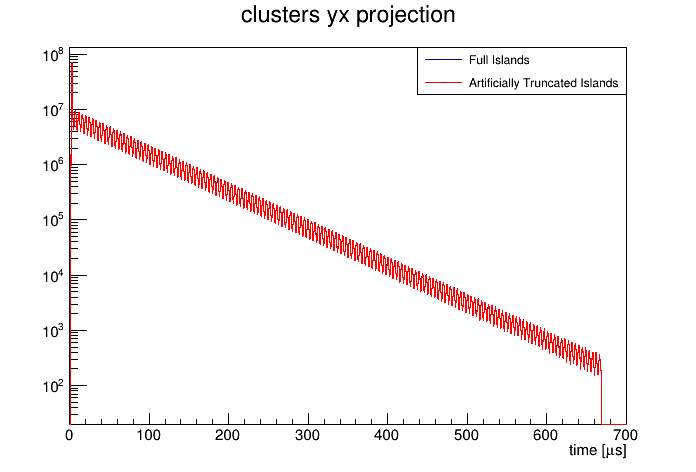

In [9]:
c = r.TCanvas()
w1.Draw("hist")
w2.Draw("SAME hist")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(w1,"Full Islands")
leg.AddEntry(w2,"Artificially Truncated Islands")
leg.Draw()

c.SetLogy()
c.Draw()

In [7]:
#time bounds in microseconds within which to do all the fits
fitBoundLow = 30
fitBoundHigh = 650

---

# Lets first do a full wiggle fit of the full islands

### 5 Parameter Fit

In [6]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'Oh wow we have to choose a new blinding phrase, huh? This is exciting!')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
#    omega = myBlinder.paramToFreq(R) unblind version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [7]:
funcFull = r.TF1("funcFull", blinded_wiggle, fitBoundLow,fitBoundHigh,5)
funcFull.SetParNames('N','#tau','A','R','#phi')
funcFull.SetParameters(7000000,64.4,0.4,-100,0)
funcFull.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
funcFull.SetLineColor(2)
funcFull.SetNpx(2000)

In [4]:
residualsFull_5Param = w1.Clone() # this will be filled with the fit residuals later
c2 = r.TCanvas()

for fit in range(2):
    print("Sarting fit:", fit+1)
    w1.Fit("funcFull","REM")
    
w1.Draw()

c2.cd(2)
ding =  w1.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

NameError: name 'w1' is not defined

### 5-Param Residuals FFT

In [14]:
def fourierXformWiggle( wigglePlot, fitFunction, fitBoundLow, fitBoundHigh, title ):
    c3 = r.TCanvas()
    residualsFull_5Param = wigglePlot.Clone() 
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow
    print(nBins)
    residVec = []
    for i in range(nBins):
        binCenterX = wigglePlot.GetXaxis().GetBinCenter(i)
        if (binCenterX > fitBoundLow and binCenterX < fitBoundHigh):
            residVec.append( (binCenterX, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX) ) )
            residualsFull_5Param.SetBinContent(i, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX))
        else:
            residualsFull_5Param.SetBinContent(i, 0)

    print(len(residVec),[residVec[i] for i in range(5)])
    centers, bins = zip(*residVec)
    htest = r.TH1D("htest","htest",len(residVec),centers[0],centers[len(residVec)-1])
    for i,ding in enumerate(bins):
        htest.SetBinContent(i, ding)

    residualsFull_5Param.Delete()
    residualsFull_5Param = htest
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow

    #apply a windows function to try to get rid of the imaginary peaks
    welchVec = []
    for i in range(nBins):
        unwindowed = residualsFull_5Param.GetBinContent(i)
        welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
        welchVec.append(welch)
        residualsFull_5Param.SetBinContent(i, unwindowed *  welch)

    residualsFull_5Param.Draw()
    residualsFull_5Param.GetXaxis().SetRangeUser(30,700)
    residualsFull_5Param.SetTitle("(Windowed) Residuals of the Fit")
    c3.Draw()    

    hxform = r.TH1D()
    hxform = 0
    r.TVirtualFFT.SetTransform(0)
    hxform = residualsFull_5Param.FFT(hxform,"MAG P")
    hxform.SetTitle( title )
    #NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
    #    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
    normXform = hxform.GetEntries()
    hxform.Scale(1/normXform)
    c2 = r.TCanvas()
    c2.cd()
    #c2.SetLogy()
    hxform.GetXaxis().SetTitle("Frequency (MHz)")
    hxform.GetYaxis().SetTitle("Arb. Units")
    hxform.Draw("HIST P0 L")
    #c2.Draw()

    Npart = residualsFull_5Param.GetSize() - 2
    minBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(0)
    maxBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(Npart)

    capT = maxBinCenter - minBinCenter
    print(Npart, capT, minBinCenter, maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print(deltaT, deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
    limmaxMHz = limmaxHz / math.pow(10.0,6)

    limmax = 2*deltaF*Npart #400-25
    print(limmax,limmaxMHz)
    #hxform.GetXaxis().SetLimits(0,limmax)
    nbins = residualsFull_5Param.GetSize() - 2
    hxform.SetBins(Npart,0,limmaxMHz)
    hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    #hxform.GetXaxis().SetRangeUser(0,1.4)

    #c2.SetLogy()
    #c2.Draw()
    #c2.Print("./images/FullIslands_5ParamResiduals.png")
    #c2.Print("./images/FullIslands_5ParamResiduals.root")
    
    return hxform;

In [15]:
ding = fourierXformWiggle( w1, funcFull, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 5-Parameter Fit [Full Islands]" )
residuals5paramXform_FullIslands = ding.Clone()

4692
4156 [(30.0618073316283, -11577.801072039641), (30.21099744245524, -6955.607119368389), (30.36018755328218, -12109.807636767626), (30.50937766410912, -15545.652359919157), (30.65856777493606, -7345.57949733315)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


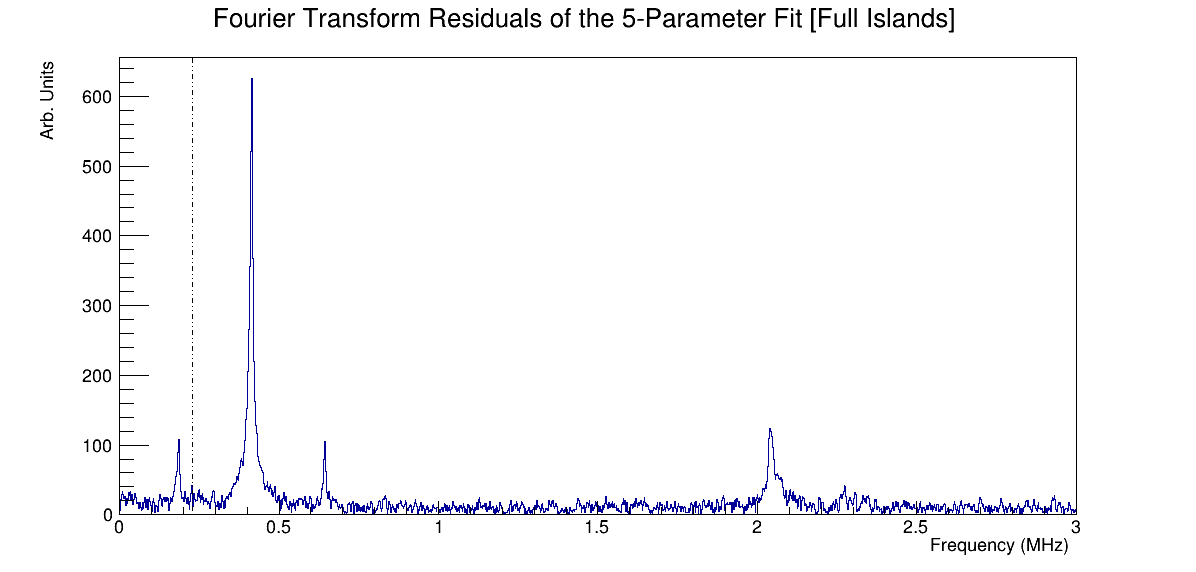

In [16]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")

f_omega_a = r.TLine(0.23,0.0000001,0.23,655)
f_omega_a.SetLineStyle(8)
f_omega_a.Draw("SAME")


c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


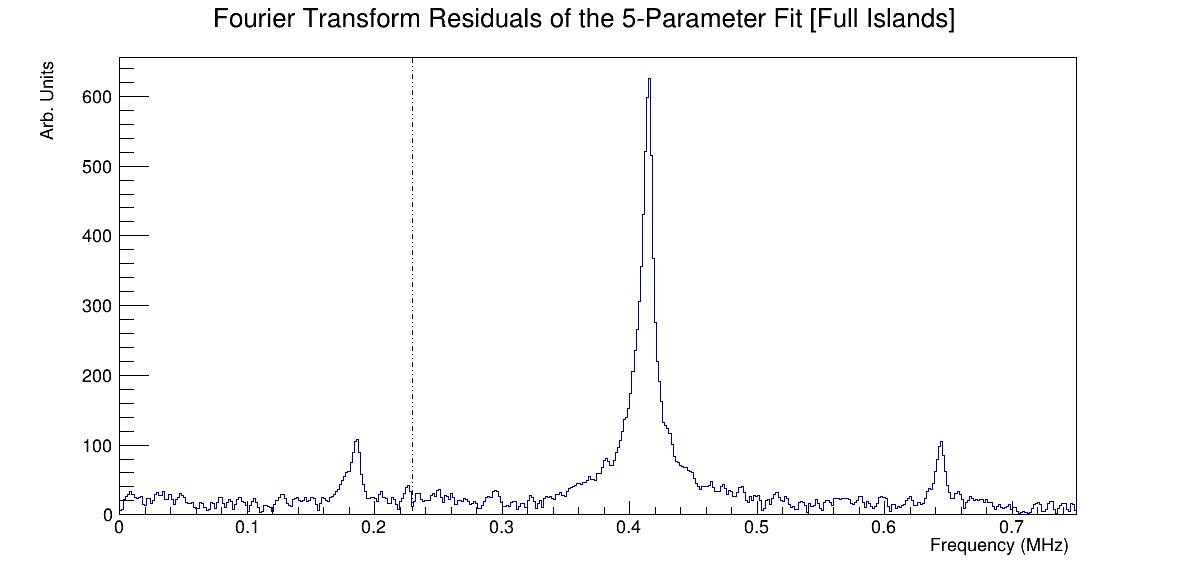

In [17]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")

f_omega_a = r.TLine(0.23,0.0000001,0.23,655)
f_omega_a.SetLineStyle(8)
f_omega_a.Draw("SAME")


c.Draw()

---

### 13-Parameter Fit

In [5]:
def blinded_wiggle_cbo(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    
    return norm * math.exp(-time/life) * cCBO * (1 - ACBO*math.cos(omega*time + phiCBO))

In [9]:
func13Full = r.TF1("func13Full", blinded_wiggle_cbo, fitBoundLow, fitBoundHigh,13)
func13Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func13Full.SetParName(11,'#phi_{CBO - 2}')
func13Full.SetParName(12,'#phi_{CBO - 3}')
func13Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
#func13Full.SetParLimits(10,-6.3,6.3)
#func13Full.SetParLimits(11,-6.3,6.3)
#func13Full.SetParLimits(12,-6.3,6.3)


#initial guesses, then updated with the first round of fit results
func13Full.SetParameters(100000, 64.32689658986958, -0.41149191856871803, 
                     -11.31981267111425, -4.201648334505292, -0.666502391530784, 
                     0.6927259503578, -0.38908021438317, 200, 
                     2.5, 0.4745581246420292)
func13Full.SetParameter(11, 6.299934663288357)
func13Full.SetParameter(12, 0.28579778778899545)
#for i in range(4):
#    func13Full.SetParameter(i, funcFull.GetParameter(i))

func13Full.SetLineColor(2)
func13Full.SetNpx(2000)

In [10]:
print([func13Full.GetParName(i) for i in range(13)])

['N', '#tau', 'A', 'R', '#phi', 'A_{1}', 'A_{2}', 'A_{3}', '#tau_{CBO}', '#omega_{CBO}', '#phi_{CBO - 1}', '#phi_{CBO - 2}', '#phi_{CBO - 3}']


In [11]:
print([func13Full.GetParameter(i) for i in range(13)])

[100000.0, 64.32689658986958, -0.41149191856871803, -11.31981267111425, -4.201648334505292, -0.666502391530784, 0.6927259503578, -0.38908021438317, 200.0, 2.5, 0.4745581246420292, 6.299934663288357, 0.28579778778899545]


Starting Fit: 1
Starting Fit: 2
 FCN=7149.04 FROM MIGRAD    STATUS=CALL LIMIT   3150 CALLS        3151 TOTAL
                     EDM=476.475    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.76117e+06   2.93208e+02  -3.64778e+01   3.10087e-03
   2  #tau         6.44206e+01   1.40789e-03   1.17390e-04   7.86715e+01
   3  A            3.72447e-01   2.78134e-05   5.87247e-06   1.10573e+05
   4  R           -4.36112e+01   8.79660e-01  -4.75183e-01  -2.44981e-01
   5  #phi        -7.34452e+00   1.41672e-04   1.13126e-04   1.46499e+03
   6  A_{1}       -1.42028e-02   4.33775e-04  -5.50100e-04  -2.54110e+04
   7  A_{2}       -9.45203e-03   7.35242e-04  -4.81105e-03  -3.78118e+04
   8  A_{3}        2.65008e-03   1.12589e-03  -5.95444e-03   1.16353e+04
   9  #tau_{CBO}   2.99353e+01   4.13171e-01   7.71732e-06  -2.17151e+06
  10  #omega_{

Warning in <Fit>: Abnormal termination of minimization.


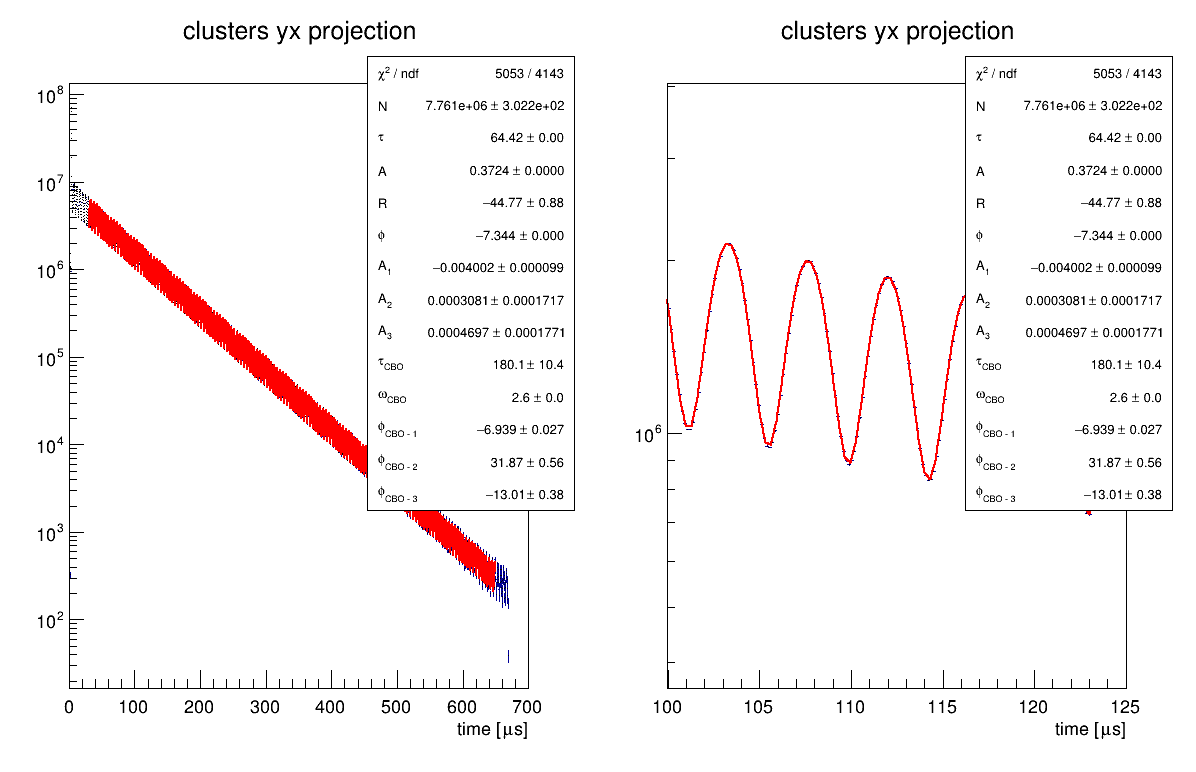

In [20]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_13 = w1.Clone()
w1_13.GetXaxis().UnZoom()

residuals13 = w1_13.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_13.Fit("func13Full","REMB")

w1_13.Draw()

c2.cd(2)
ding13 =  w1_13.Clone()
ding13.GetXaxis().SetRangeUser(100,125)
ding13.Draw()

r.gPad.SetLogy()
c2.Draw()

In [21]:
parameters13Full = []
for i in range(13):
    parameters13Full.append( (func13Full.GetParameter(i) , func13Full.GetParError(i)) )
#print(parameters13)
par13,parErr13 = zip(*parameters13Full)
print(par13)

(7760830.288177743, 64.42178958116753, 0.3724051230125594, -44.77087500729618, -7.344250611288412, -0.004002489121117461, 0.0003080508971619568, 0.0004697366556882337, 180.0773416439048, 2.5999197546217716, -6.939488466213013, 31.871909885057953, -13.014893793993858)


In [22]:
ding = fourierXformWiggle( w1, func13Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 13-Parameter Fit [Full Islands]" )
residuals13paramXform_FullIslands = ding.Clone()
residuals13paramXform_FullIslands.SetLineColor(6)

4692
4156 [(30.0618073316283, -3919.662058203481), (30.21099744245524, 4690.883210903034), (30.36018755328218, 1091.522379196249), (30.50937766410912, -3051.329657644499), (30.65856777493606, 2688.813519531861)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


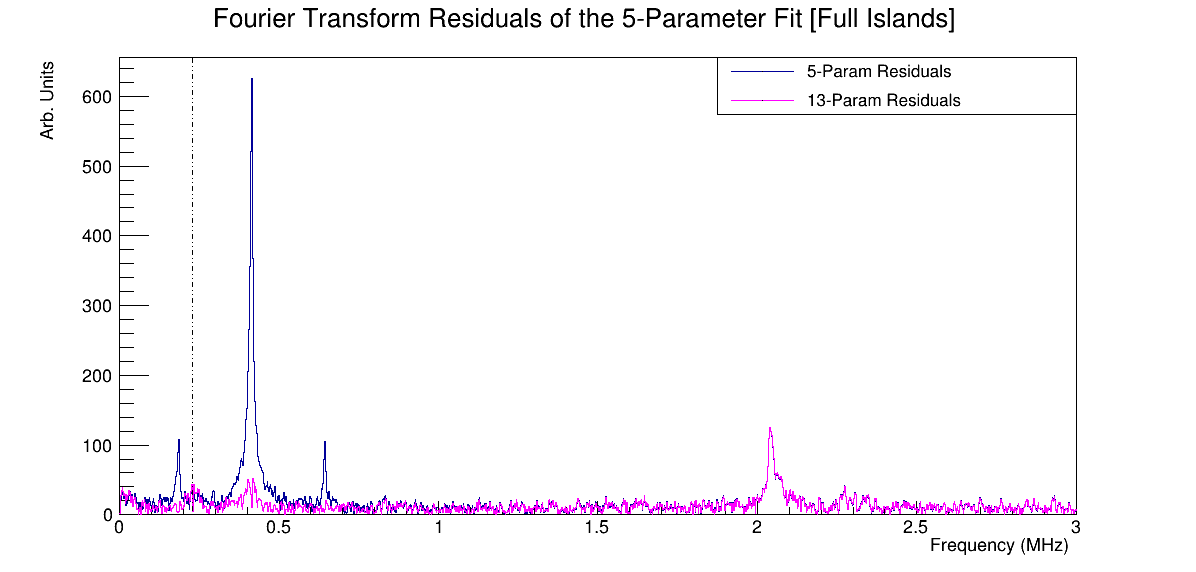

In [23]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


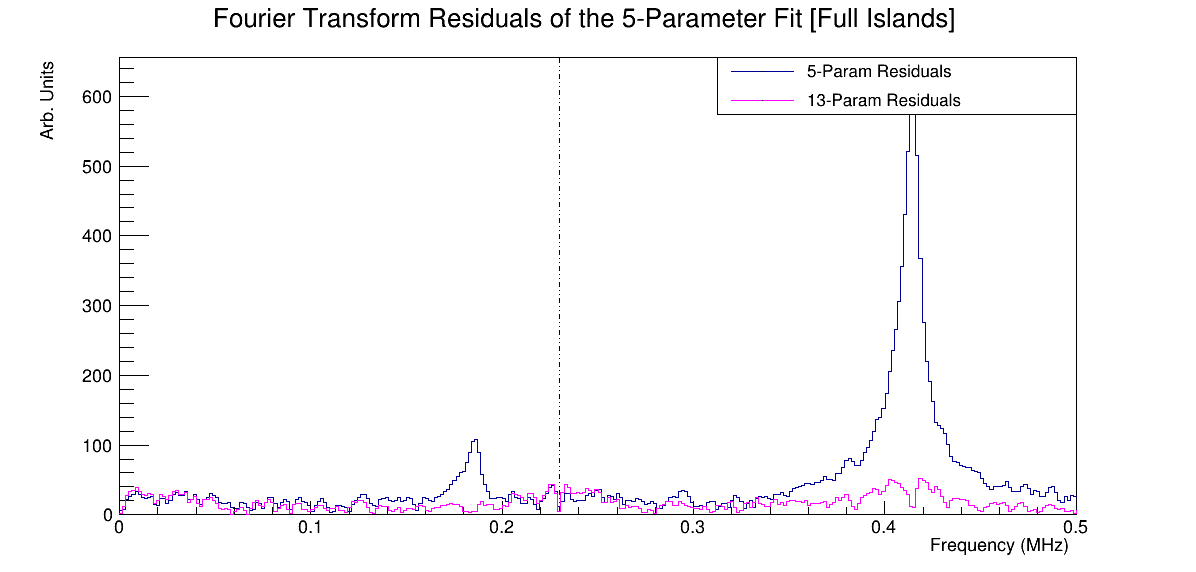

In [24]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,.5)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### 17-Parameter Fit with vertical waist term

In [12]:
def blinded_wiggle_cbo_vw(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO))

In [13]:
func17Full = r.TF1("func17Full", blinded_wiggle_cbo_vw,  fitBoundLow, fitBoundHigh,17)
func17Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func17Full.SetParName(11,'#phi_{CBO - 2}')
func17Full.SetParName(12,'#phi_{CBO - 3}')
func17Full.SetParName(13,'A_{VW}')
func17Full.SetParName(14,'#tau_{VW}')
func17Full.SetParName(15,'#omega_{VW}')
func17Full.SetParName(16,'#phi_{VW}')
func17Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func17Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(13):
    func17Full.SetParameter(i, func13Full.GetParameter(i))
func17Full.SetParameter(13, 0.2)
func17Full.SetParameter(14, 30)
func17Full.SetParameter(15, 12.83)
func17Full.SetParameter(16, 0)

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func17Full.SetLineColor(4)
func17Full.SetNpx(2000)

In [15]:
print([func17Full.GetParName(i) for i in range(17)])

['N', '#tau', 'A', 'R', '#phi', 'A_{1}', 'A_{2}', 'A_{3}', '#tau_{CBO}', '#omega_{CBO}', '#phi_{CBO - 1}', '#phi_{CBO - 2}', '#phi_{CBO - 3}', 'A_{VW}', '#tau_{VW}', '#omega_{VW}', '#phi_{VW}']


In [14]:
print([func17Full.GetParameter(i) for i in range(17)])

[100000.0, 64.32689658986958, -0.41149191856871803, -11.31981267111425, -4.201648334505292, -0.666502391530784, 0.6927259503578, -0.38908021438317, 200.0, 2.5, 0.4745581246420292, 6.299934663288357, 0.28579778778899545, 0.2, 30.0, 12.83, 0.0]


In [ ]:
v

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.1056032525254302
       7760827.929519809 +/- 302.2468616804143
       64.42179885472925 +/- 0.001412645425145892
       0.37240514682114056 +/- 2.9255718396371376e-05
       -44.7931915144964 +/- 0.8799858106752826
       -7.344245434242523 +/- 0.00014455596963000898
       -0.004007637291527253 +/- 9.892333709308129e-05
       0.00030894959648729726 +/- 0.0001718062651091365
       -0.0004604323580178785 +/- 0.0001771735406652121
       179.6698418044771 +/- 10.317607321286275
       2.5999099444648825 +/- 0.0003511903181446278
       -6.938607044803597 +/- 0.026687691892062933
       69.57998263049431 +/- 0.5571407403988697
       -9.881241293510692 +/- 0.3885995711019556
       0.004144891026260258 +/- 0.000702709440155278
       30.589045002606913 +/- 3.572563922471513
       12.830163964528866 +/- 0.004111925647268686
       -7.57666373408046 +/- 0.18080876928183579
Starting Fit: 2
     Parameters from fit 2 :
  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


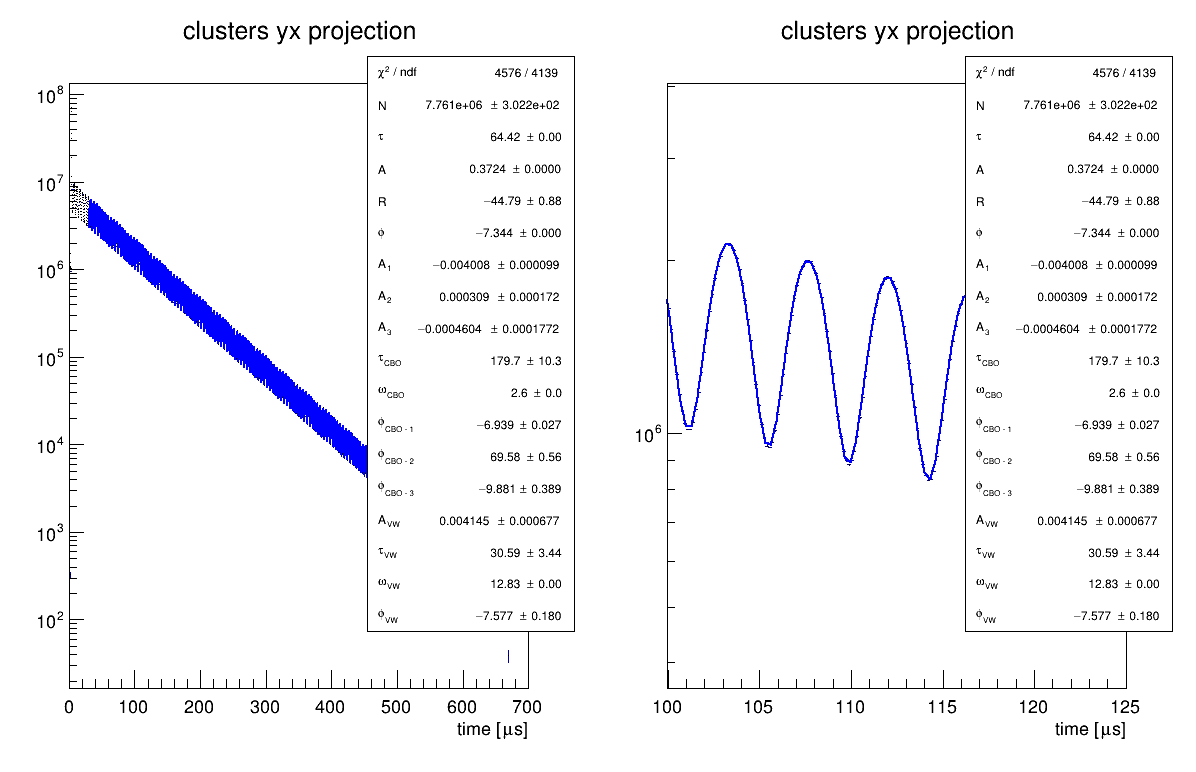

In [27]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_17 = w1.Clone()
w1_17.GetXaxis().UnZoom()

residuals17 = w1_17.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_17.Fit("func17Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func17Full.GetChisquare() / func17Full.GetNDF() )
    for i in range(17):
        print( "      ", func17Full.GetParameter(i) ,"+/-", func17Full.GetParError(i) ) 

w1_17.Draw()

c2.cd(2)
ding17 =  w1_17.Clone()
ding17.GetXaxis().SetRangeUser(100,125)
ding17.Draw()

r.gPad.SetLogy()
c2.Draw()

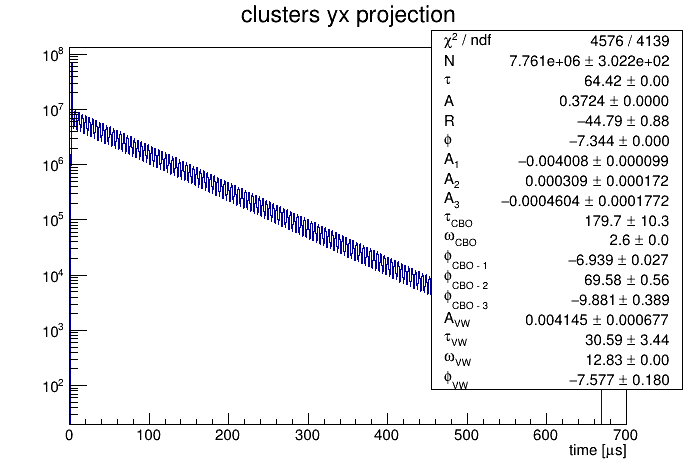

In [28]:
c = r.TCanvas()
w1_17.Draw("hist")
c.SetLogy()
c.Draw()

In [29]:
ding = fourierXformWiggle( w1, func17Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 17-Parameter Fit [Full Islands]" )
residuals17paramXform_FullIslands = ding.Clone()
residuals17paramXform_FullIslands.SetLineColor(3)

4692
4156 [(30.0618073316283, -426.7109424350783), (30.21099744245524, -2669.1785331591964), (30.36018755328218, 2783.260550844483), (30.50937766410912, 2120.5375888650306), (30.65856777493606, -1831.7731885262765)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


In [30]:
parameters17Full = []
for i in range(17):
    parameters17Full.append( (func17Full.GetParameter(i) , func17Full.GetParError(i)) )
#print(parameters13)
par17,parErr17 = zip(*parameters17Full)
print(par17)

(7760827.92307183, 64.42179879341674, 0.3724051483309719, -44.793181016649086, -7.344245435335661, -0.004007635947183725, 0.000308950423276895, -0.00046044073241345373, 179.6695087653253, 2.599909954329649, -6.938606347755444, 69.57987713913056, -9.881126276458755, 0.004144899914384842, 30.589098781810225, 12.830164127918309, -7.576656648370284)


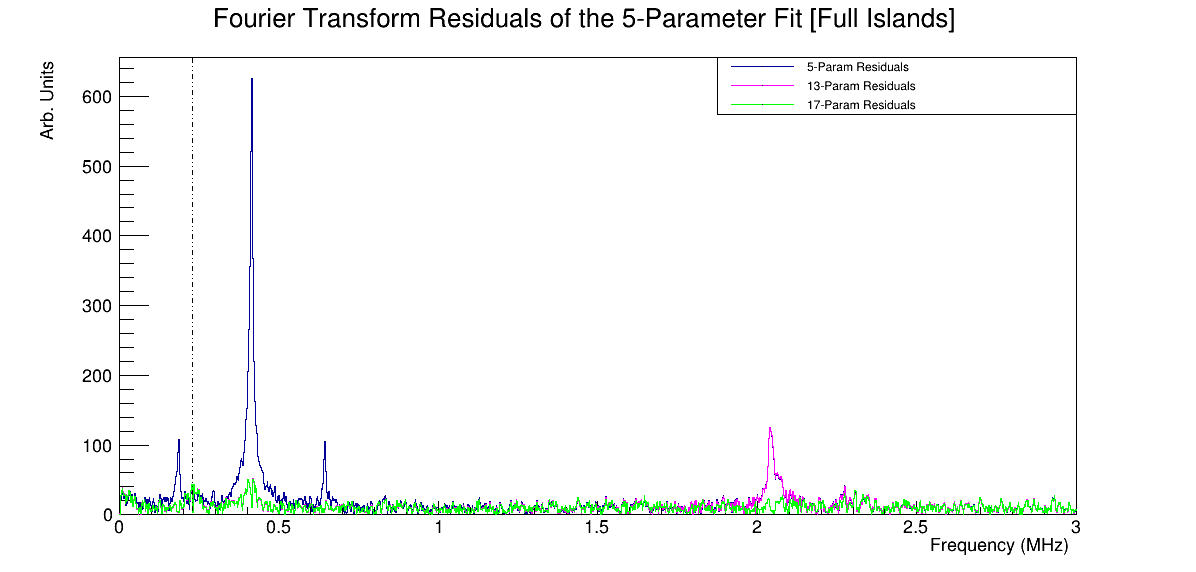

In [31]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


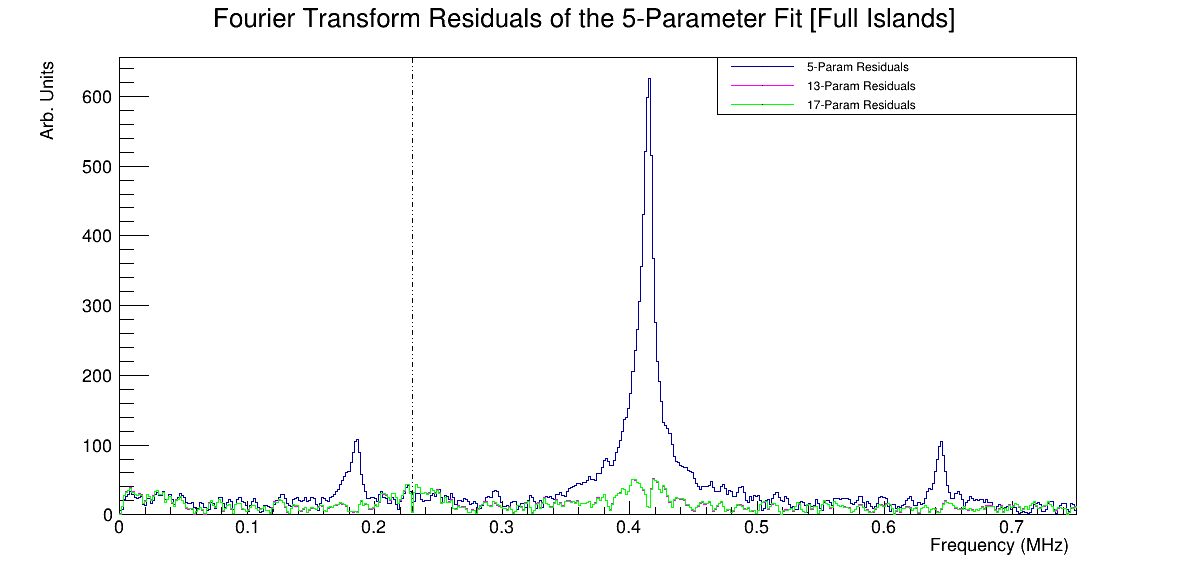

In [32]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


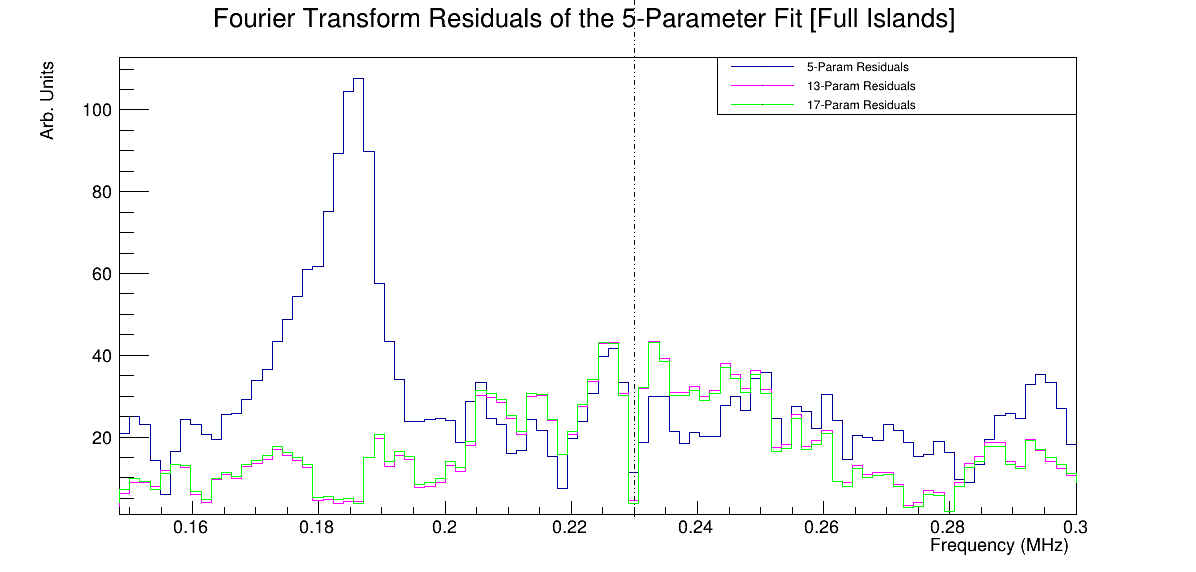

In [33]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0.15,0.3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### 18-Parameter Fit with all this and a K<sub>loss</sub> term

In [34]:
f_Kloss = r.TFile("./Kloss/kloss_firstTry.root")
f.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected.root	
  OBJ: TH1D		clusters yx projection : 0 at: 0x7fffe0e7c3c0
  OBJ: TH1D	w1	clusters yx projection : 0 at: 0x7fffe0e73370
  KEY: TCanvas	c1;1	c1


In [35]:
c_Kloss = f_Kloss.Get("c1_n4")
print([x for x in c_Kloss.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7f74e542b4c0>, <ROOT.TH1D object ("KlossInt") at 0x7f74e549ad80>, <ROOT.TPaveText object ("title") at 0x7f74dd57d8b0>]


In [36]:
KlossHist = c_Kloss.GetPrimitive("KlossInt").Clone()
KlossHist.SetDirectory(0)

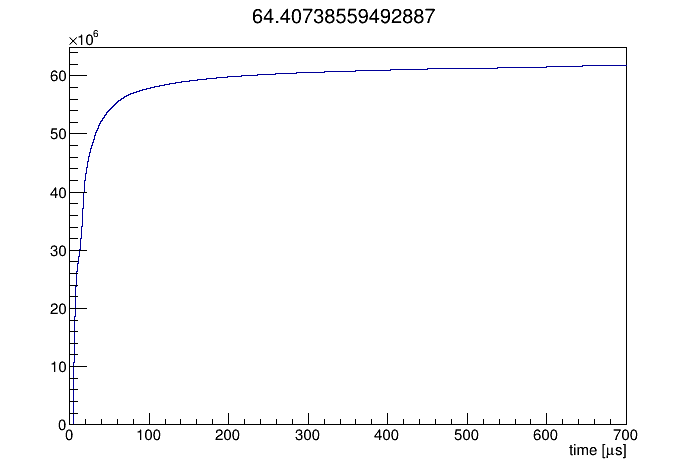

In [37]:
c = r.TCanvas()
KlossHist.Draw()
c.Draw()

In [38]:
def blinded_wiggle_cbo_vw_Kloss(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    Kloss    = p[17]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return ( norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO)) 
            * (1 - Kloss*KlossHist.GetBinContent(KlossHist.FindBin(time))) )

In [39]:
func18Full = r.TF1("func18Full", blinded_wiggle_cbo_vw_Kloss,  fitBoundLow, fitBoundHigh,18)
func18Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func18Full.SetParName(11,'#phi_{CBO - 2}')
func18Full.SetParName(12,'#phi_{CBO - 3}')
func18Full.SetParName(13,'A_{VW}')
func18Full.SetParName(14,'#tau_{VW}')
func18Full.SetParName(15,'#omega_{VW}')
func18Full.SetParName(16,'#phi_{VW}')
func18Full.SetParName(17,'K_{loss}')
func18Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func18Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(17):
    func18Full.SetParameter(i, func17Full.GetParameter(i))
#func18Full.SetParameter(13, 0.2)
#func18Full.SetParameter(14, 30)
#func18Full.SetParameter(15, 12.83)
func18Full.SetParameter(17, 10**(-10))

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func18Full.SetLineColor(4)
func18Full.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.096113075082142
       7792648.247563862 +/- 5015.8592403618195
       64.43394167678777 +/- 0.0023767126551842957
       0.37241177367936074 +/- 2.9274500396271678e-05
       -44.90121414639282 +/- 0.8799662288601391
       -7.344220905600104 +/- 0.00014458602643237686
       -0.0040323293184684 +/- 9.968545880363624e-05
       0.0002750530519812942 +/- 0.00017250296383642115
       -0.0004134359252690383 +/- 0.00017794239254115979
       177.82252795814003 +/- 10.152082374759175
       2.5998935449865694 +/- 0.000351077851886071
       -6.937686614790826 +/- 0.02661355350555952
       69.63029448665013 +/- 0.6283317148339705
       -9.782513994062052 +/- 0.43461939563101687
       0.004152447876250835 +/- 0.0007055943315159634
       30.53636705726777 +/- 3.57078597523763
       12.830544119558855 +/- 0.004130729543944916
       -7.596719167014474 +/- 0.18152173414412626
       7.775841147804828e-11 +/- 1.21847043052

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


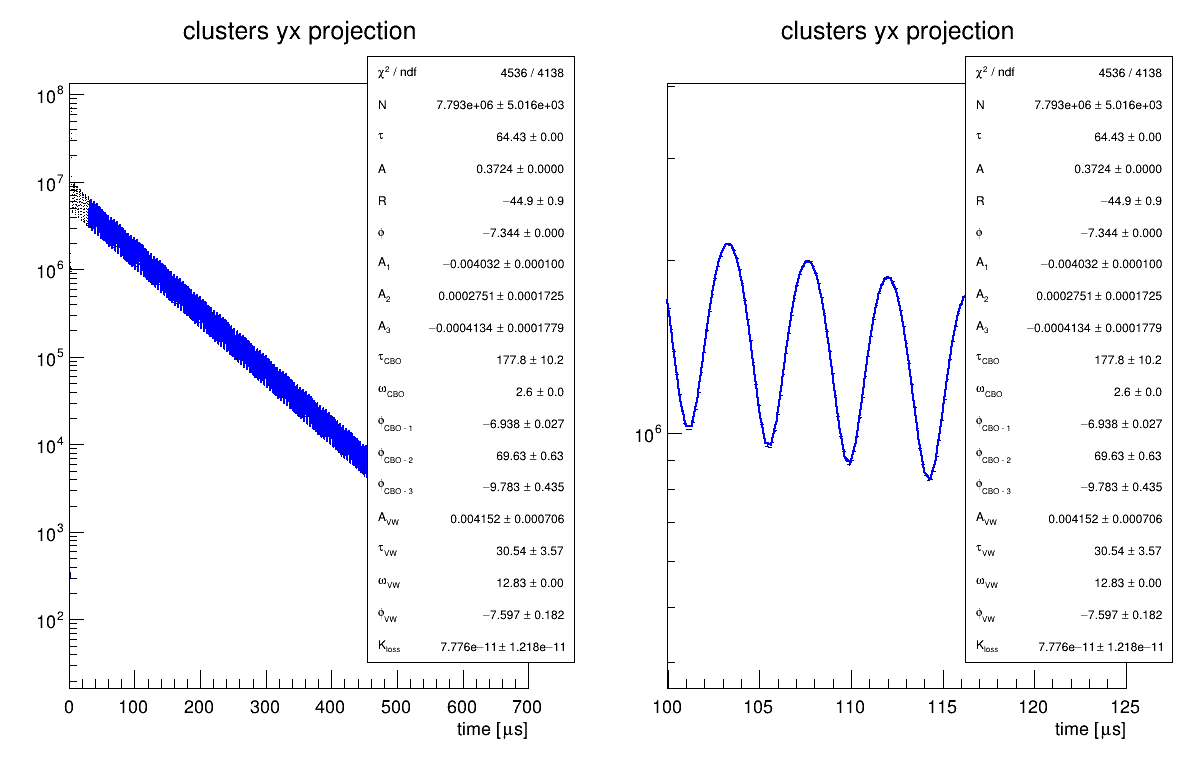

In [40]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_18 = w1.Clone()
w1_18.GetXaxis().UnZoom()

residuals18 = w1_18.Clone() # this will be filled with the fit residuals later

for i in range(1): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_18.Fit("func18Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func18Full.GetChisquare() / func18Full.GetNDF() )
    for i in range(18):
        print( "      ", func18Full.GetParameter(i) ,"+/-", func18Full.GetParError(i) ) 

w1_18.Draw()

c2.cd(2)
ding18 =  w1_18.Clone()
ding18.GetXaxis().SetRangeUser(100,125)
ding18.Draw()

r.gPad.SetLogy()
c2.Draw()

In [41]:
ding = fourierXformWiggle( w1, func18Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 18-Parameter Fit [Full Islands]" )
residuals18paramXform_FullIslands = ding.Clone()
residuals18paramXform_FullIslands.SetLineColor(46)

4692
4156 [(30.0618073316283, -2210.7357834763825), (30.21099744245524, -4305.184395837598), (30.36018755328218, 1278.9804592318833), (30.50937766410912, 875.3555568922311), (30.65856777493606, -2961.6745357145555)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


In [42]:
parameters18Full = []
for i in range(18):
    parameters18Full.append( (func18Full.GetParameter(i) , func18Full.GetParError(i)) )
#print(parameters13)
par18,parErr18 = zip(*parameters18Full)
print(par18)

(7792648.247563862, 64.43394167678777, 0.37241177367936074, -44.90121414639282, -7.344220905600104, -0.0040323293184684, 0.0002750530519812942, -0.0004134359252690383, 177.82252795814003, 2.5998935449865694, -6.937686614790826, 69.63029448665013, -9.782513994062052, 0.004152447876250835, 30.53636705726777, 12.830544119558855, -7.596719167014474, 7.775841147804828e-11)


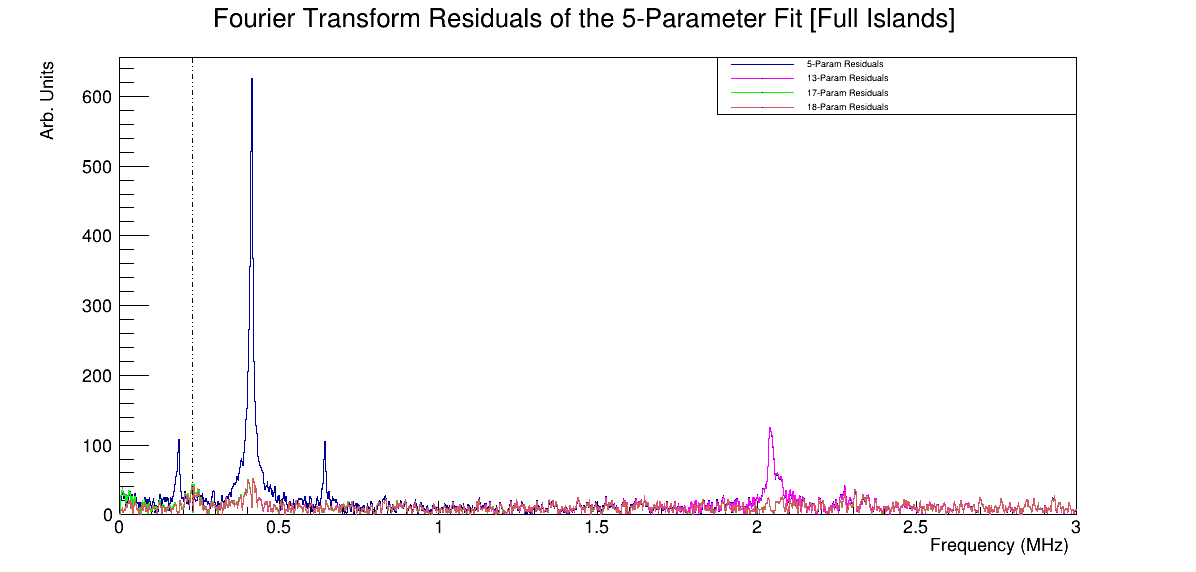

In [43]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


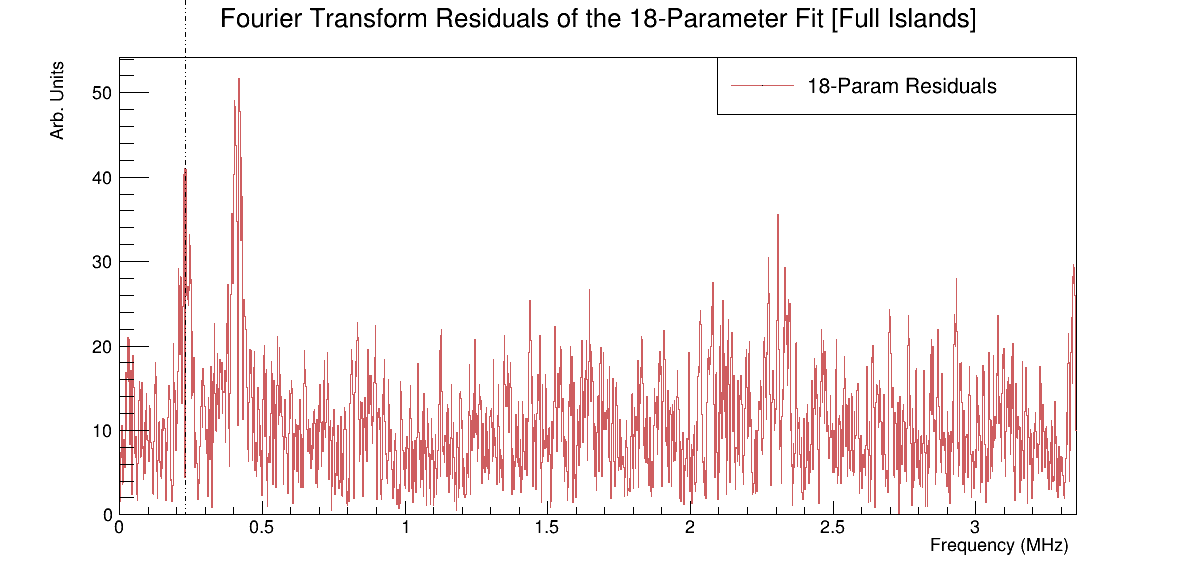

In [44]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
#residuals5paramXform_FullIslands.Draw("hist")
#residuals13paramXform_FullIslands.Draw("hist same")
#residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
#leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
#leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
#leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()
c.Print("./images/18_Param_Residuals_Full.root")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


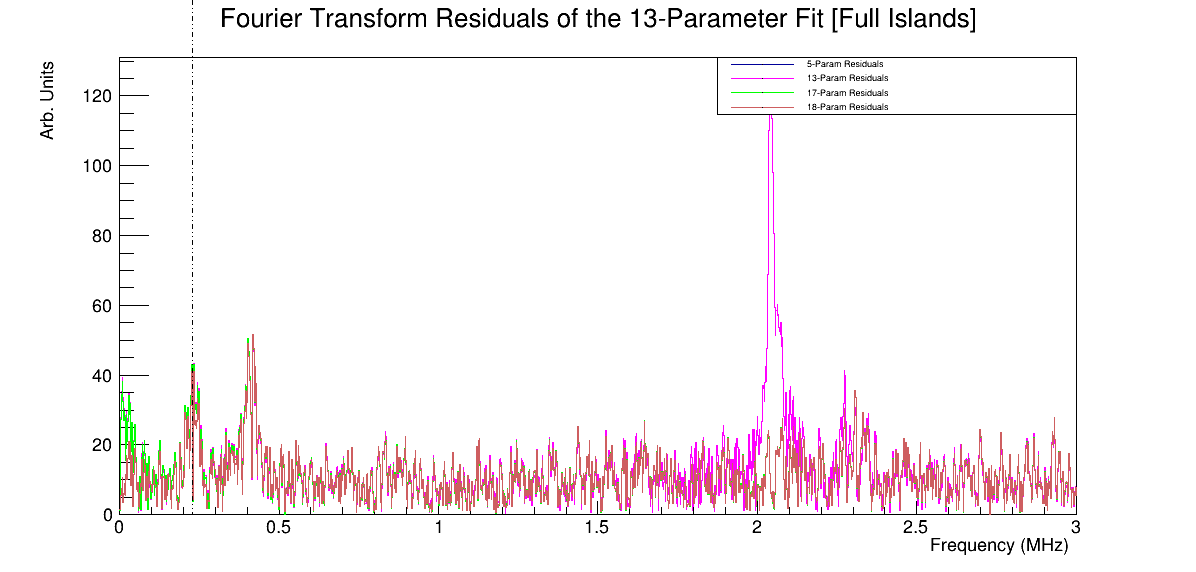

In [45]:
c = r.TCanvas("c","c",1200,600)
residuals13paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist ")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


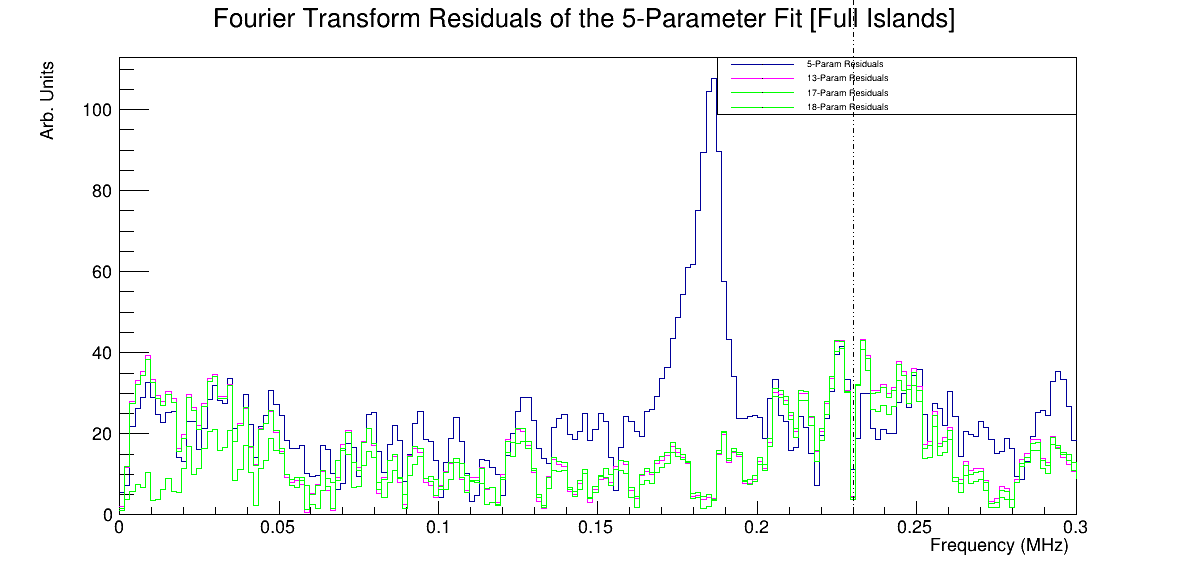

In [92]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,.3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveAs>: ROOT file ./images/Residuals_18Par_Full.root has been created


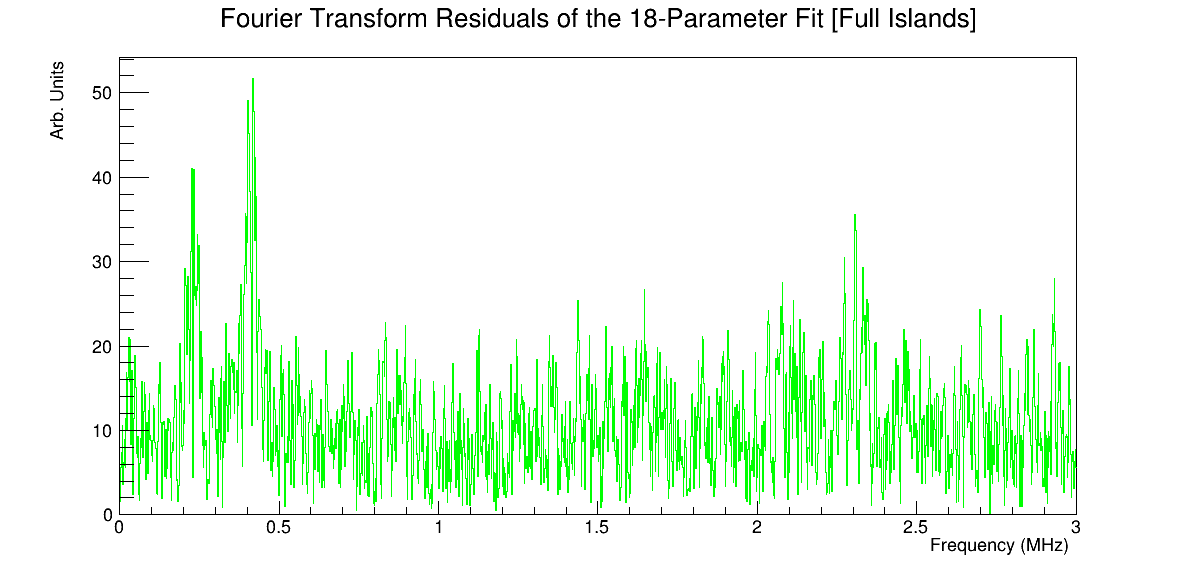

In [103]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,.3)
residuals18paramXform_FullIslands.Draw("hist")

c.Draw()
c.Print("./images/Residuals_18Par_Full.root")

---

### And now lets add in a changing CBO term of the form in docDB 15376

In [94]:
def blinded_wiggle_cbo_vw_Kloss_changingCBO(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    #changing cbo freq
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    Kloss    = p[17]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    omegaCBO = p[9] * (1 + p[18]*time + p[19]*math.exp(-time / p[20]) + p[21]*math.exp( -time / p[22] ) )
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return ( norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO)) 
            * (1 - Kloss*KlossHist.GetBinContent(KlossHist.FindBin(time))) )

In [110]:
func23Full = r.TF1("func23Full", blinded_wiggle_cbo_vw_Kloss_changingCBO,  fitBoundLow, fitBoundHigh,23)
func23Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}^{0}','#phi_{CBO - 1}')
func23Full.SetParName(11,'#phi_{CBO - 2}')
func23Full.SetParName(12,'#phi_{CBO - 3}')
func23Full.SetParName(13,'A_{VW}')
func23Full.SetParName(14,'#tau_{VW}')
func23Full.SetParName(15,'#omega_{VW}')
func23Full.SetParName(16,'#phi_{VW}')
func23Full.SetParName(17,'K_{loss}')
func23Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func23Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(18):
    func23Full.SetParameter(i, func18Full.GetParameter(i))

func23Full.SetParameter(18, 1.856 )
func23Full.SetParameter(19, -5.22)
func23Full.SetParameter(20, 73.4)
func23Full.SetParameter(21, -13.05)
func23Full.SetParameter(22, 16.09)

func23Full.SetParName(18,'#delta#omega_{CBO}')
func23Full.SetParName(19,'A_{CBO(t)}')
func23Full.SetParName(20,'#tau_{A-CBO(t)}')
func23Full.SetParName(21,'B_{CBO(t)}')
func23Full.SetParName(22,'#tau_{B-CBO(t)}')


#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func23Full.SetLineColor(9)
func23Full.SetNpx(2000)

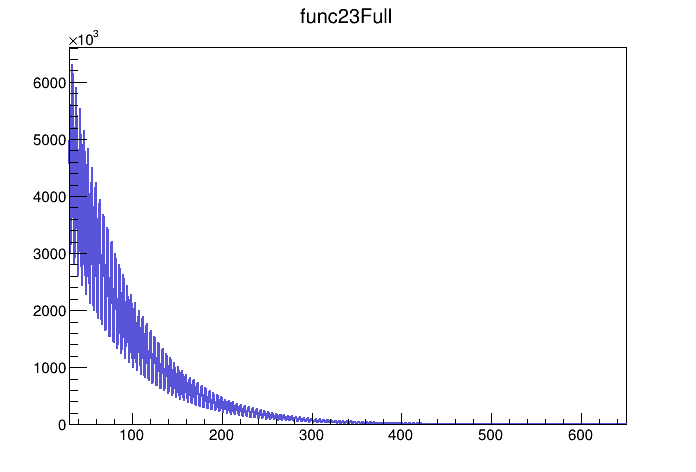

In [111]:
c = r.TCanvas()
func23Full.Draw()
c.Draw()

In [ ]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_23 = w1.Clone()
w1_23.GetXaxis().UnZoom()

residuals23 = w1_23.Clone() # this will be filled with the fit residuals later

for i in range(1): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_23.Fit("func23Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("        ChiSq / NDF = ", func23Full.GetChisquare() / func23Full.GetNDF() )
    for i in range(23):
        print( "        ", func23Full.GetParName(i), "=", func23Full.GetParameter(i) ,"+/-", func23Full.GetParError(i) ) 

w1_23.Draw()

c2.cd(2)
ding23 =  w1_23.Clone()
ding23.GetXaxis().SetRangeUser(100,125)
ding23.Draw()

r.gPad.SetLogy()
c2.Draw()

Starting Fit: 1


In [ ]:
ding = fourierXformWiggle( w1, func23Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 23-Parameter Fit [Full Islands]" )
residuals23paramXform_FullIslands = ding.Clone()
residuals23paramXform_FullIslands.SetLineColor(38)

In [ ]:
parameters23Full = []
for i in range(23):
    parameters23Full.append( (func23Full.GetParameter(i) , func23Full.GetParError(i)) )
#print(parameters13)
par23,parErr23 = zip(*parameters23Full)
print(par23)

In [ ]:
c = r.TCanvas("c","c",1200,600)
residuals18paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
#residuals5paramXform_FullIslands.Draw("hist")
#residuals13paramXform_FullIslands.Draw("hist same")
#residuals17paramXform_FullIslands.Draw("hist same")
residuals23paramXform_FullIslands.Draw("hist ")
residuals18paramXform_FullIslands.Draw("hist same ")

leg = r.TLegend(0.6,0.8,0.9,0.9)
#leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
#leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
#leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.AddEntry(residuals23paramXform_FullIslands,"23-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

# And now onto the truncated version

### 5-Parameter Fit

In [47]:
funcTrunc = r.TF1("funcTrunc", blinded_wiggle, fitBoundLow,fitBoundHigh,5)
funcTrunc.SetParNames('N','#tau','A','R','#phi')
funcTrunc.SetParameters(7000000,64.4,0.4,0,0)
funcTrunc.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
funcTrunc.SetLineColor(2)
funcTrunc.SetNpx(2000)

Sarting fit: 1
Sarting fit: 2
 FCN=12014.7 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         492 TOTAL
                     EDM=5.68154e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.74703e+06   3.01635e+02  -5.87856e-03  -3.01118e-13
   2  #tau         6.44245e+01   1.41304e-03  -1.70038e-07   6.04971e-05
   3  A            3.72786e-01   2.91761e-05  -9.62885e-09  -7.57238e-06
   4  R           -4.62151e+01   8.77447e-01   1.85778e-04  -5.13010e-08
   5  #phi        -1.06073e+00   1.43766e-04   1.43766e-04   3.13244e-03
 FCN=12014.7 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         282 TOTAL
                     EDM=1.01091e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   

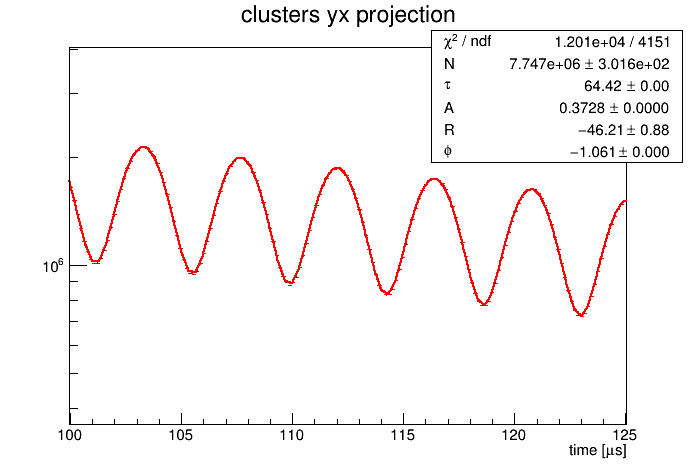

In [48]:
residualsTrunc_5Param = w2.Clone() # this will be filled with the fit residuals later
c2 = r.TCanvas()

for fit in range(2):
    print("Sarting fit:", fit+1)
    w2.Fit("funcTrunc","REM")

chiSqFivePar_Full = ( ( funcTrunc.GetNDF(),
                        funcTrunc.GetChisquare(),
                        funcTrunc.GetProb() ) )
    
w2.Draw()

c2.cd(2)
ding =  w2.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

### 5-Param Residuals FFT

In [49]:
ding = fourierXformWiggle( w2, funcTrunc, fitBoundLow, fitBoundHigh, 
                          "Fourier Transform Residuals of the 5-Parameter Fit [Truncated Islands]" )
residuals5paramXform_TruncIslands = ding.Clone()

4692
4156 [(30.0618073316283, -11831.26968078781), (30.21099744245524, -7375.6275091981515), (30.36018755328218, -12271.082161955535), (30.50937766410912, -16092.976201605517), (30.65856777493606, -7844.398664446082)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


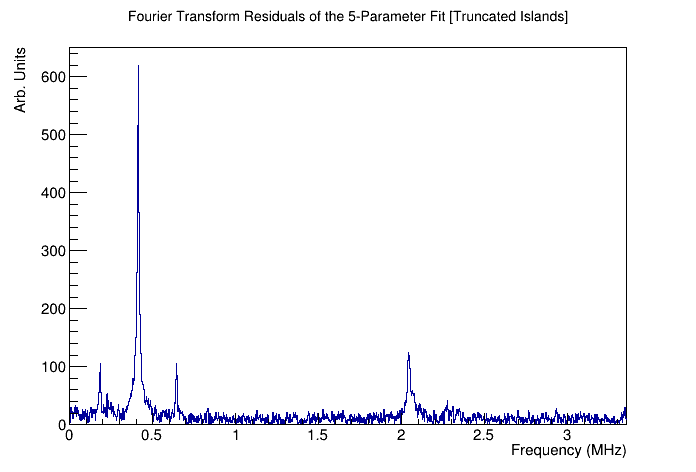

In [50]:
c = r.TCanvas()
residuals5paramXform_TruncIslands.Draw("hist")
c.Draw()

---

### 13-Parameter Fit

In [51]:
func13Trunc = r.TF1("func13Trunc", blinded_wiggle_cbo, fitBoundLow, fitBoundHigh,13)
func13Trunc.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func13Trunc.SetParName(11,'#phi_{CBO - 2}')
func13Trunc.SetParName(12,'#phi_{CBO - 3}')
func13Trunc.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
#func13Trunc.SetParLimits(10,-6.3,6.3)
#func13Trunc.SetParLimits(11,-6.3,6.3)
#func13Trunc.SetParLimits(12,-6.3,6.3)


#initial guesses, then updated with the first round of fit results
func13Trunc.SetParameters(100000, 64.32689658986958, -0.41149191856871803, 
                     -11.31981267111425, -4.201648334505292, -0.666502391530784, 
                     0.6927259503578, -0.38908021438317, 200, 
                     2.5, 0.4745581246420292)
func13Trunc.SetParameter(11, 6.299934663288357)
func13Trunc.SetParameter(12, 0.28579778778899545)
for i in range(4):
    func13Trunc.SetParameter(i, funcTrunc.GetParameter(i))

func13Trunc.SetLineColor(2)
func13Trunc.SetNpx(2000)

Starting Fit: 1
Starting Fit: 2
 FCN=10167.3 FROM MIGRAD    STATUS=CALL LIMIT   3148 CALLS        3149 TOTAL
                     EDM=68.8358    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.1 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.74707e+06   3.08635e+02  -7.76422e+01  -1.94785e-02
   2  #tau         6.44243e+01   1.43008e-03   2.57744e-04  -1.20555e+03
   3  A            3.72914e-01   2.96696e-05   7.00948e-06   1.30786e+05
   4  R           -4.32662e+01   8.89633e-01   6.98232e-02  -3.01660e+00
   5  #phi        -7.34463e+00   1.47519e-04  -1.90488e-05  -4.74631e+04
   6  A_{1}       -3.90455e-01   3.65630e-02   2.58928e-02   2.82294e+02
   7  A_{2}       -1.84439e-01   4.41887e-02  -2.51933e-02  -3.77742e+02
   8  A_{3}       -1.09295e-01   4.38496e-02   7.91631e-02  -1.86941e+02
   9  #tau_{CBO}   7.15740e+00   9.05188e-02   3.44890e-06** at limit **
 

Warning in <Fit>: Abnormal termination of minimization.


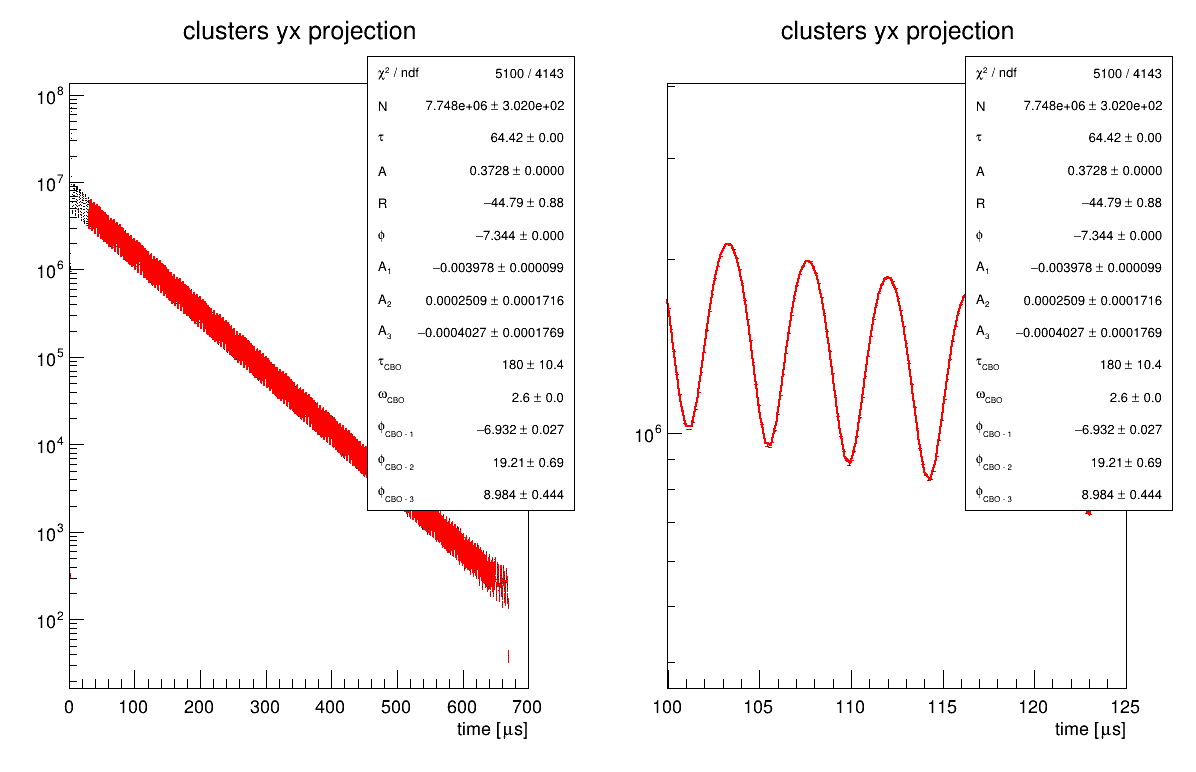

In [52]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w2_13 = w2.Clone()
w2_13.GetXaxis().UnZoom()

residuals13 = w2_13.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w2_13.Fit("func13Trunc","REMB")

w2_13.Draw()

c2.cd(2)
ding13 =  w2_13.Clone()
ding13.GetXaxis().SetRangeUser(100,125)
ding13.Draw()

r.gPad.SetLogy()
c2.Draw()

In [53]:
parameters13Trunc = []
for i in range(13):
    parameters13Trunc.append( (func13Trunc.GetParameter(i) , func13Trunc.GetParError(i)) )
#print(parameters13)
par13,parErr13 = zip(*parameters13Trunc)
print(par13)

(7747508.601853841, 64.42295073056424, 0.37281531108276045, -44.79054534082732, -7.344243447363986, -0.003977696136756663, 0.0002509119853447928, -0.00040267154847484926, 180.01524108587554, 2.5998994183604105, -6.932362666504128, 19.206467446161682, 8.98397259272658)


In [54]:
ding = fourierXformWiggle( w2, func13Trunc, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 13-Parameter Fit [Truncated Islands]" )
residuals13paramXform_TruncIslands = ding.Clone()
residuals13paramXform_TruncIslands.SetLineColor(6)

4692
4156 [(30.0618073316283, -4053.2459228495136), (30.21099744245524, 4330.004499131814), (30.36018755328218, 938.3424821589142), (30.50937766410912, -3624.161594982259), (30.65856777493606, 2151.708405648824)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


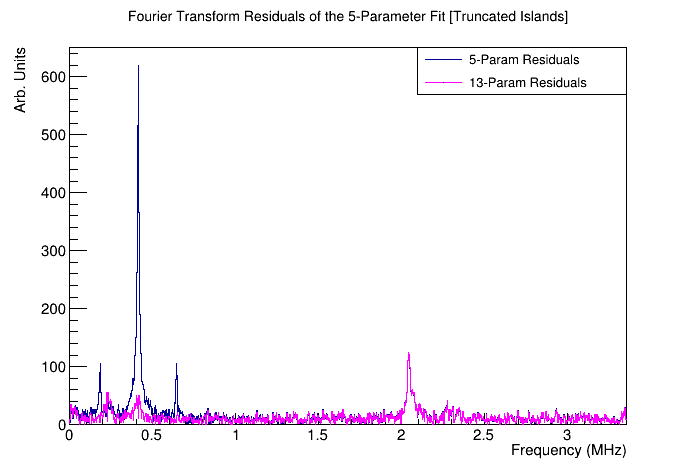

In [55]:
c = r.TCanvas()
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
leg.Draw()

c.Draw()

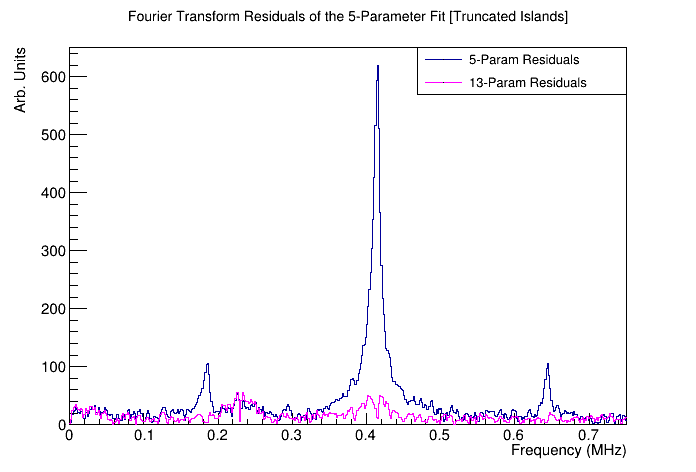

In [56]:
c = r.TCanvas()
residuals5paramXform_TruncIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
leg.Draw()

c.Draw()

---

### and now 17-param (finally)

In [57]:
func17Trunc = r.TF1("func17Trunc", blinded_wiggle_cbo_vw,  fitBoundLow, fitBoundHigh,17)
func17Trunc.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func17Trunc.SetParName(11,'#phi_{CBO - 2}')
func17Trunc.SetParName(12,'#phi_{CBO - 3}')
func17Trunc.SetParName(13,'A_{VW}')
func17Trunc.SetParName(14,'#tau_{VW}')
func17Trunc.SetParName(15,'#omega_{VW}')
func17Trunc.SetParName(16,'#phi_{VW}')
func17Trunc.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func17Trunc.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Trunc.SetParLimits(10,-6.3,6.3) 
#func17Trunc.SetParLimits(11,-6.3,6.3)
#func17Trunc.SetParLimits(12,-6.3,6.3)
#func17Trunc.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(13):
    func17Trunc.SetParameter(i, func13Full.GetParameter(i))
func17Trunc.SetParameter(13, 0.2)
func17Trunc.SetParameter(14, 30)
func17Trunc.SetParameter(15, 12.83)
func17Trunc.SetParameter(16, 0)


#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func17Trunc.SetLineColor(4)
func17Trunc.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
       7747506.3541455325 +/- 301.9672010310575
       64.42295941973906 +/- 0.001413803142902649
       0.3728153373295638 +/- 2.927635018600385e-05
       -44.81320731889366 +/- 0.879786364156746
       -7.344238208509764 +/- 0.00014450330738837765
       -0.003982945075149431 +/- 9.893713379859528e-05
       0.0002514321123789955 +/- 0.0001717523530428898
       -0.00039334278397947696 +/- 0.00017698550448787018
       179.59485123516728 +/- 10.373520353823537
       2.5998895540321727 +/- 0.0003541520443707974
       -6.9314784651961965 +/- 0.026903453607940275
       38.066095402374984 +/- 0.6842657653732166
       -22.440926105608874 +/- 0.45469079449111804
       0.004154552716742134 +/- 0.0007017189859735845
       30.62480395396246 +/- 3.566412704048002
       12.830273230325979 +/- 0.004095253180542539
       -7.579939682604884 +/- 0.18013288772644692
Starting Fit: 2
     Parameters from fit 2 :
       7747506.358995543 +/- 301.964

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


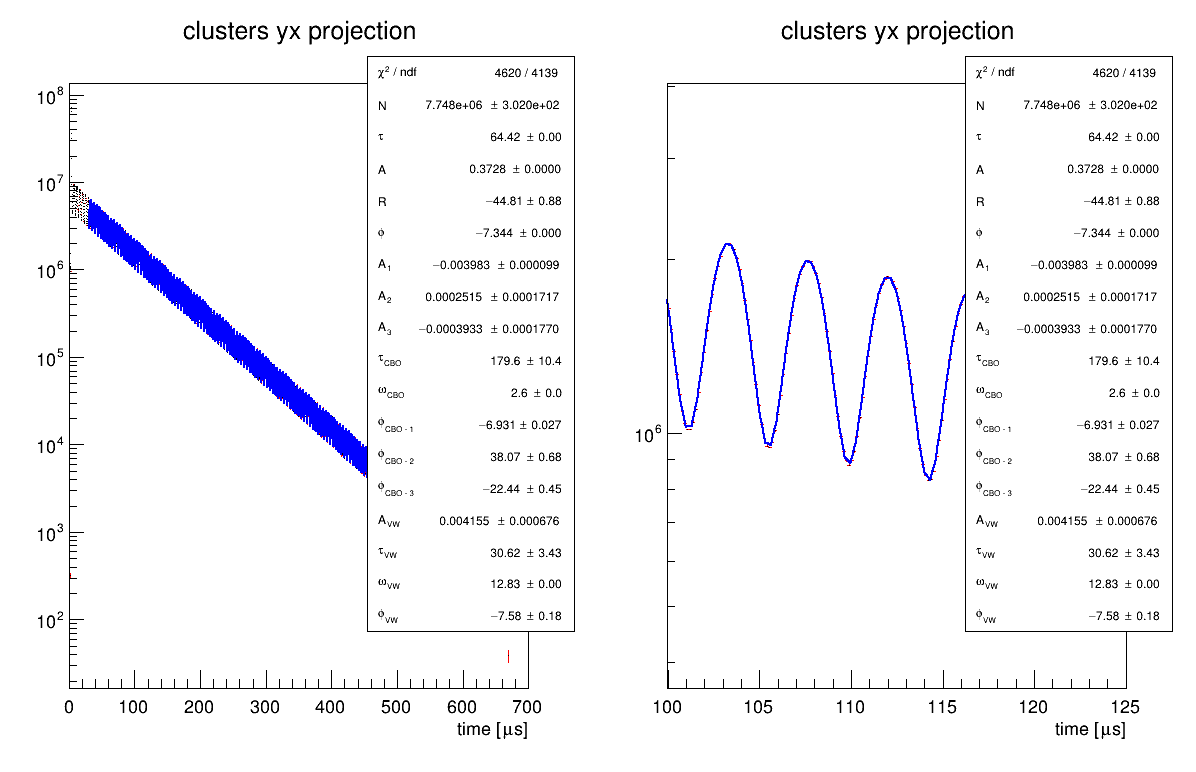

In [58]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w2_17 = w2.Clone()
w2_17.GetXaxis().UnZoom()

residuals17 = w2_17.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w2_17.Fit("func17Trunc","REMB")
    print("     Parameters from fit", i+1,":")
    for i in range(17):
        print( "      ", func17Trunc.GetParameter(i) ,"+/-", func17Trunc.GetParError(i) ) 

w2_17.Draw()

c2.cd(2)
ding17 =  w2_17.Clone()
ding17.GetXaxis().SetRangeUser(100,125)
ding17.Draw()

r.gPad.SetLogy()
c2.Draw()

In [59]:
ding = fourierXformWiggle( w2, func17Trunc, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 17-Parameter Fit [Trunc Islands]" )
residuals17paramXform_TruncIslands = ding.Clone("residuals17paramXform_TruncIslands")
residuals17paramXform_TruncIslands.SetLineColor(3)

4692
4156 [(30.0618073316283, -554.0069278916344), (30.21099744245524, -3042.8337750118226), (30.36018755328218, 2633.364631303586), (30.50937766410912, 1555.7998761567287), (30.65856777493606, -2375.536106478423)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


In [60]:
parameters17Trunc = []
for i in range(17):
    parameters17Trunc.append( (func17Trunc.GetParameter(i) , func17Trunc.GetParError(i)) )
#print(parameters13)
par17,parErr17 = zip(*parameters17Trunc)
print(par17)

(7747506.358995543, 64.42295940611973, 0.3728153380934046, -44.81324087181419, -7.344238227600681, -0.0039829412087491805, 0.00025148547021899733, -0.00039329179757156954, 179.5950918093945, 2.599889540231328, -6.93147774651854, 38.06648581875233, -22.440991145258135, 0.004154548018629327, 30.62483684987068, 12.830273499505676, -7.579928678053075)


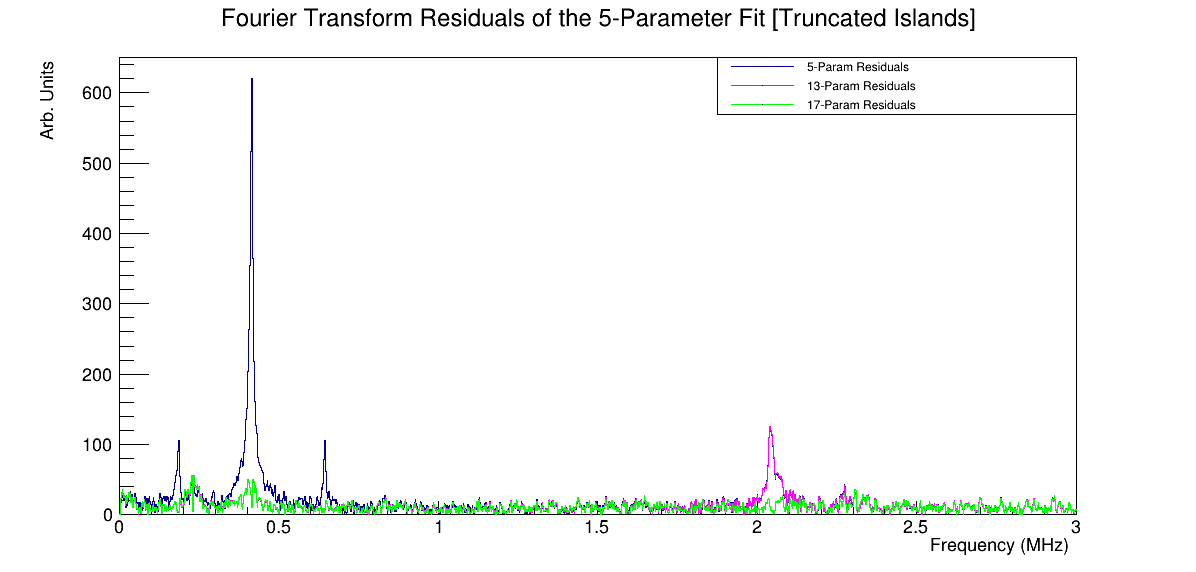

In [61]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_TruncIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")
residuals17paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_TruncIslands,"17-Param Residuals")
leg.Draw()

c.Draw()

---

### And now with the K<sub>loss</sub> term

In [62]:
f_Kloss = r.TFile("./Kloss/kloss_trunc_firstTry.root")
f_Kloss.ls()

TFile**		./Kloss/kloss_trunc_firstTry.root	
 TFile*		./Kloss/kloss_trunc_firstTry.root	
  KEY: TCanvas	c1_n4;1	c1_n4


In [63]:
c_Kloss = f_Kloss.Get("c1_n4")
print([x for x in c_Kloss.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7f74e53cf7c0>, <ROOT.TH1D object ("KlossIntTrunc") at 0x7f74e5488a10>, <ROOT.TPaveText object ("title") at 0x7f74e53f6210>]


In [64]:
KlossHistTrunc = c_Kloss.GetPrimitive("KlossIntTrunc").Clone()
KlossHistTrunc.SetDirectory(0)

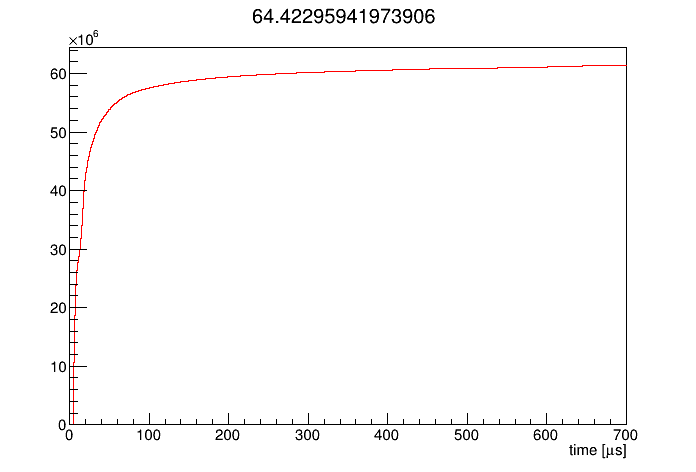

In [65]:
c = r.TCanvas()
KlossHistTrunc.Draw()
c.Draw()

In [66]:
def blinded_wiggle_cbo_vw_Kloss_trunc(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    Kloss    = p[17]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return ( norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO)) 
            * (1 - Kloss*KlossHist.GetBinContent(KlossHistTrunc.FindBin(time))) )

In [67]:
func18Trunc = r.TF1("func18Trunc", blinded_wiggle_cbo_vw_Kloss_trunc,  fitBoundLow, fitBoundHigh,18)
func18Trunc.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func18Trunc.SetParName(11,'#phi_{CBO - 2}')
func18Trunc.SetParName(12,'#phi_{CBO - 3}')
func18Trunc.SetParName(13,'A_{VW}')
func18Trunc.SetParName(14,'#tau_{VW}')
func18Trunc.SetParName(15,'#omega_{VW}')
func18Trunc.SetParName(16,'#phi_{VW}')
func18Trunc.SetParName(17,'K_{loss}')
func18Trunc.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func18Trunc.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(17):
    func18Trunc.SetParameter(i, func17Trunc.GetParameter(i))
#func18Full.SetParameter(13, 0.2)
#func18Full.SetParameter(14, 30)
#func18Full.SetParameter(15, 12.83)
func18Trunc.SetParameter(17, 10**(-10))

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func18Trunc.SetLineColor(4)
func18Trunc.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.109552581160009
       7774278.799119386 +/- 5011.626067679024
       64.43319285631307 +/- 0.002378527602247886
       0.3728209221409418 +/- 2.9295075930091167e-05
       -44.90391835426704 +/- 0.8797987771284704
       -7.344217609650241 +/- 0.00014453756015986042
       -0.004003888390750113 +/- 9.96025742372065e-05
       0.0002216172644955766 +/- 0.0001723779326113332
       -0.0003536232393450873 +/- 0.00017768607629611738
       178.011265278357 +/- 10.231842190178142
       2.599875629043164 +/- 0.00035405292829420517
       -6.930708924479829 +/- 0.026839643164287975
       38.105272657198775 +/- 0.7791120930398524
       -22.343477513397477 +/- 0.5076166834864432
       0.004160630765952237 +/- 0.0007040466865198613
       30.581784221741476 +/- 3.564953840462511
       12.830591491283263 +/- 0.004110977601697592
       -7.596736696006662 +/- 0.1807317103822446
       6.55774420574822e-11 +/- 1.2211017041257

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


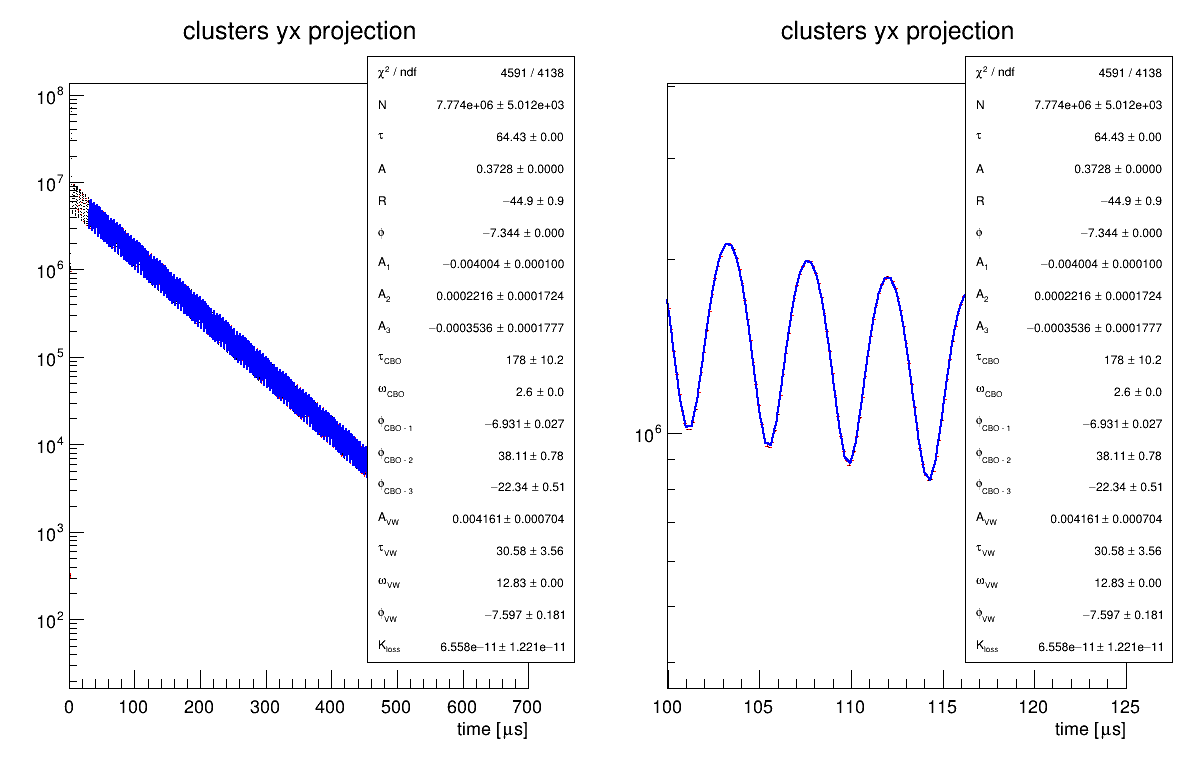

In [68]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w2_18 = w2.Clone()
w2_18.GetXaxis().UnZoom()

residuals18 = w2_18.Clone() # this will be filled with the fit residuals later

for i in range(1): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w2_18.Fit("func18Trunc","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func18Trunc.GetChisquare() / func18Trunc.GetNDF() )
    for i in range(18):
        print( "      ", func18Trunc.GetParameter(i) ,"+/-", func18Trunc.GetParError(i) ) 

w2_18.Draw()

c2.cd(2)
ding18 =  w2_18.Clone()
ding18.GetXaxis().SetRangeUser(100,125)
ding18.Draw()

r.gPad.SetLogy()
c2.Draw()

In [69]:
ding = fourierXformWiggle( w2, func18Trunc, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 18-Parameter Fit [Trunc Islands]" )
residuals18paramXform_TruncIslands = ding.Clone()
residuals18paramXform_TruncIslands.SetLineColor(48)

4692
4156 [(30.0618073316283, -2054.597677201964), (30.21099744245524, -4418.558910343796), (30.36018755328218, 1368.4338829396293), (30.50937766410912, 508.723250862211), (30.65856777493606, -3325.4992299769074)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


In [70]:
parameters18Trunc = []
for i in range(18):
    parameters18Trunc.append( (func18Trunc.GetParameter(i) , func18Trunc.GetParError(i)) )
#print(parameters13)
par18,parErr18 = zip(*parameters18Trunc)
print(par18)

(7774278.799119386, 64.43319285631307, 0.3728209221409418, -44.90391835426704, -7.344217609650241, -0.004003888390750113, 0.0002216172644955766, -0.0003536232393450873, 178.011265278357, 2.599875629043164, -6.930708924479829, 38.105272657198775, -22.343477513397477, 0.004160630765952237, 30.581784221741476, 12.830591491283263, -7.596736696006662, 6.55774420574822e-11)


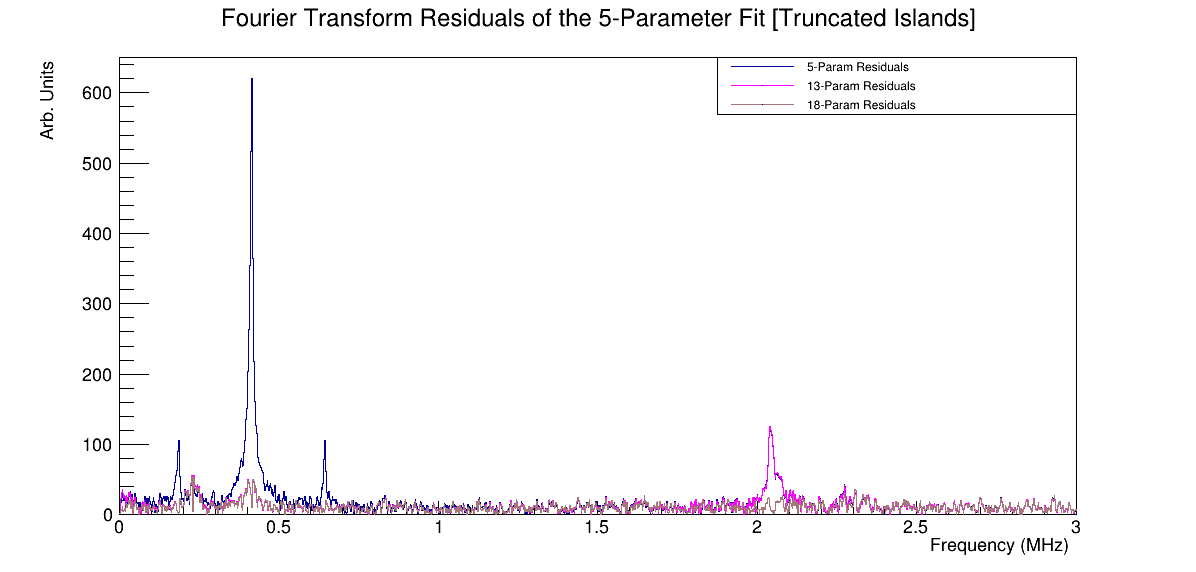

In [71]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_TruncIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_TruncIslands.Draw("hist")
residuals13paramXform_TruncIslands.Draw("hist same")
#residuals17paramXform_TruncIslands.Draw("hist same")
residuals18paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
#leg.AddEntry(residuals17paramXform_TruncIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_TruncIslands,"18-Param Residuals")
leg.Draw()

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


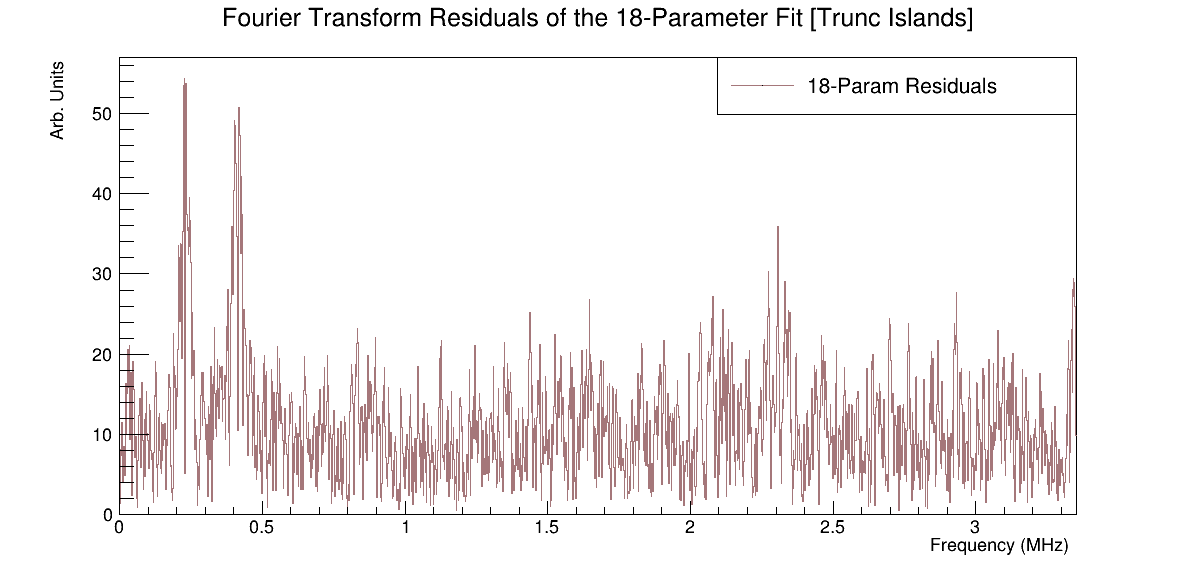

In [72]:
c = r.TCanvas("c","c",1200,600)
#residuals5paramXform_TruncIslands.GetXaxis().SetRangeUser(0,3)
#residuals5paramXform_TruncIslands.Draw("hist")
#residuals13paramXform_TruncIslands.Draw("hist same")
#residuals17paramXform_TruncIslands.Draw("hist same")
residuals18paramXform_TruncIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
#leg.AddEntry(residuals5paramXform_TruncIslands,"5-Param Residuals")
#leg.AddEntry(residuals13paramXform_TruncIslands,"13-Param Residuals")
#leg.AddEntry(residuals17paramXform_TruncIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_TruncIslands,"18-Param Residuals")
leg.Draw()

c.Draw()

---

# And now for the comparison 

N  ----  (7774278.799119386, 5011.626067679024) (7792648.247563862, 5015.8592403618195)
#tau  ----  (64.43319285631307, 0.002378527602247886) (64.43394167678777, 0.0023767126551842957)
A  ----  (0.3728209221409418, 2.9295075930091167e-05) (0.37241177367936074, 2.9274500396271678e-05)
R  ----  (-44.90391835426704, 0.8797987771284704) (-44.90121414639282, 0.8799662288601391)
#phi  ----  (-7.344217609650241, 0.00014453756015986042) (-7.344220905600104, 0.00014458602643237686)
A_{1}  ----  (-0.004003888390750113, 9.96025742372065e-05) (-0.0040323293184684, 9.968545880363624e-05)
A_{2}  ----  (0.0002216172644955766, 0.0001723779326113332) (0.0002750530519812942, 0.00017250296383642115)
A_{3}  ----  (-0.0003536232393450873, 0.00017768607629611738) (-0.0004134359252690383, 0.00017794239254115979)
#tau_{CBO}  ----  (178.011265278357, 10.231842190178142) (177.82252795814003, 10.152082374759175)
#omega_{CBO}  ----  (2.599875629043164, 0.00035405292829420517) (2.5998935449865694, 0.00035107785188

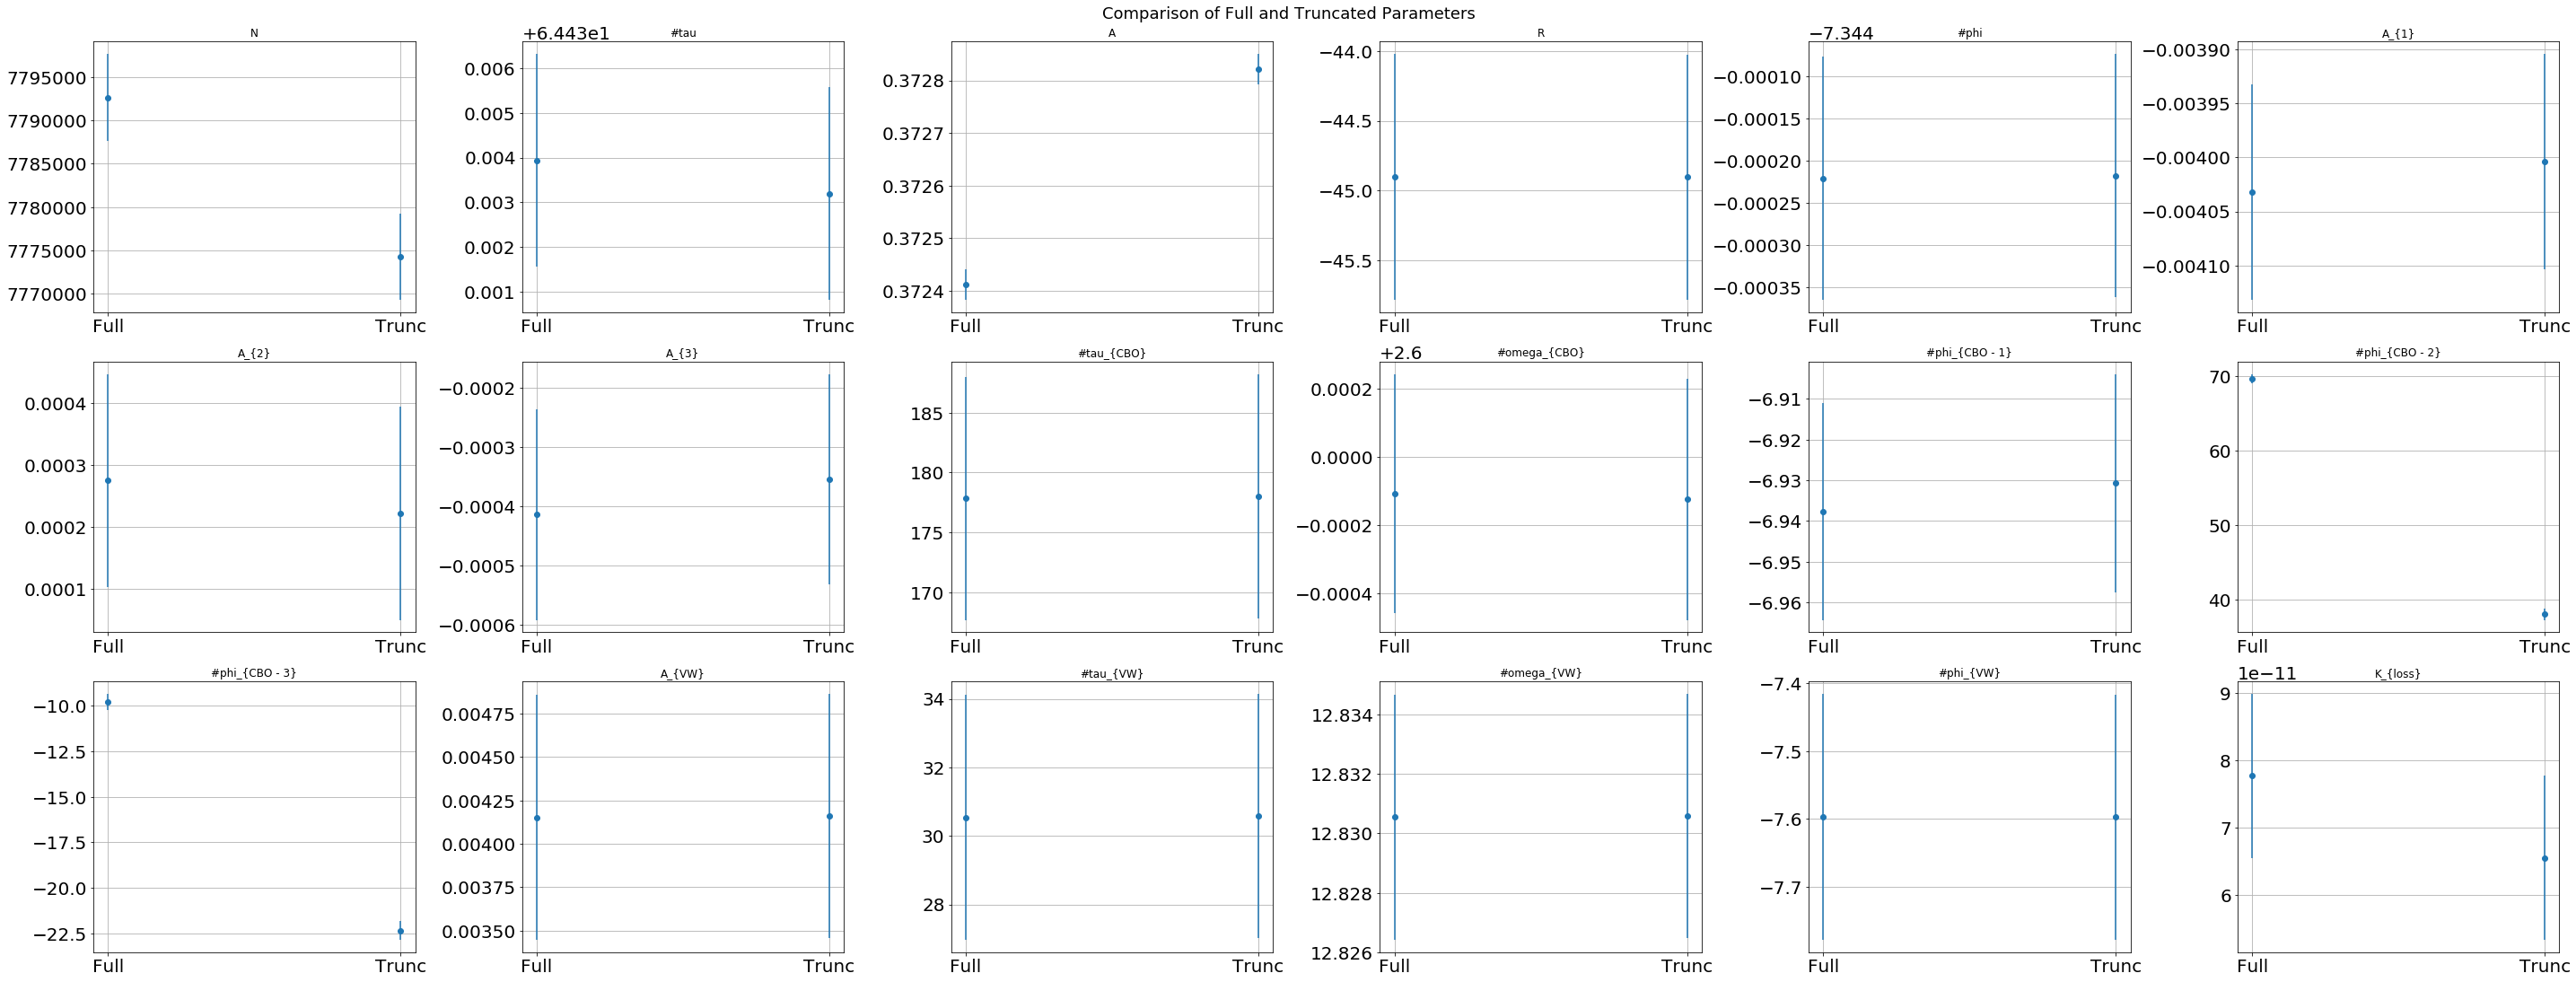

In [73]:
width = 6
height = int(np.ceil( len(parameters18Trunc) / width ) )

fig, ax = plt.subplots(height, width, figsize=(40,15))
for i, fTrunc in enumerate(parameters18Trunc):
    fFull = parameters18Full[i]
    print(func18Trunc.GetParName(i)," ---- ", fTrunc, fFull)
    axi = ax[int(np.floor(i / width))][i % width]
    
    pars = [fFull[0], fTrunc[0]]
    parErrs = [fFull[1], fTrunc[1]]
    
    axi.errorbar( [x for x in range(len(fFull))], pars, xerr=0, yerr=parErrs, fmt="o")
    axi.set_title(func18Trunc.GetParName(i))
    plt.sca(axi)
    plt.grid()
    plt.xticks(np.arange(2), ('Full', 'Trunc'))

plt.suptitle("Comparison of Full and Truncated Parameters", y=1.01, size=18)
plt.tight_layout()
plt.show()

In [74]:
i = 11
print(func18Trunc.GetParName(i)," ---- ", parameters18Trunc[i], parameters18Full[i])
x1 = (parameters18Trunc[i][0]+r.TMath.Pi()*10 , parameters18Trunc[i][1])
x2 = parameters18Full[i]
print(func18Trunc.GetParName(i)," ---- ", x1, x2)

#phi_{CBO - 2}  ----  (38.105272657198775, 0.7791120930398524) (69.63029448665013, 0.6283317148339705)
#phi_{CBO - 2}  ----  (69.5211991930967, 0.7791120930398524) (69.63029448665013, 0.6283317148339705)


In [75]:
i = 12
print(func18Trunc.GetParName(i)," ---- ", parameters18Trunc[i], parameters18Full[i])
print(func18Trunc.GetParName(i)," ---- ", (parameters18Trunc[i][0]+r.TMath.Pi()*4 , parameters18Trunc[i][1]), parameters18Full[i])

#phi_{CBO - 3}  ----  (-22.343477513397477, 0.5076166834864432) (-9.782513994062052, 0.43461939563101687)
#phi_{CBO - 3}  ----  (-9.777106899038305, 0.5076166834864432) (-9.782513994062052, 0.43461939563101687)


In [76]:
print("chiSq / NDF Full:", func18Full.GetChisquare(),"/", func18Full.GetNDF(),"=", func18Full.GetChisquare() / func18Full.GetNDF())
print("chiSq / NDF Trunc:", func18Trunc.GetChisquare(),"/", func18Trunc.GetNDF(),"=", func18Trunc.GetChisquare() / func18Trunc.GetNDF())

chiSq / NDF Full: 4535.715904689903 / 4138 = 1.096113075082142
chiSq / NDF Trunc: 4591.328580840118 / 4138 = 1.109552581160009


In [77]:
print("R Value Full:", func18Full.GetParameter(3), "+/-",  func18Full.GetParError(3) )
print("R Value Truncated:", func18Trunc.GetParameter(3), "+/-",  func18Trunc.GetParError(3) )

print("delta R = ",  func18Full.GetParameter(3) - func18Trunc.GetParameter(3) )
print("        = ", (func18Full.GetParameter(3) - func18Trunc.GetParameter(3))*1000, "ppb")

R Value Full: -44.90121414639282 +/- 0.8799662288601391
R Value Truncated: -44.90391835426704 +/- 0.8797987771284704
delta R =  0.002704207874224096
        =  2.704207874224096 ppb


In [78]:
residDiff_5param = residuals5paramXform_FullIslands.Clone("residDiff_5param")
residDiff_5param.GetXaxis().UnZoom()
residDiff_5param.Add(residuals5paramXform_TruncIslands, -1)

True

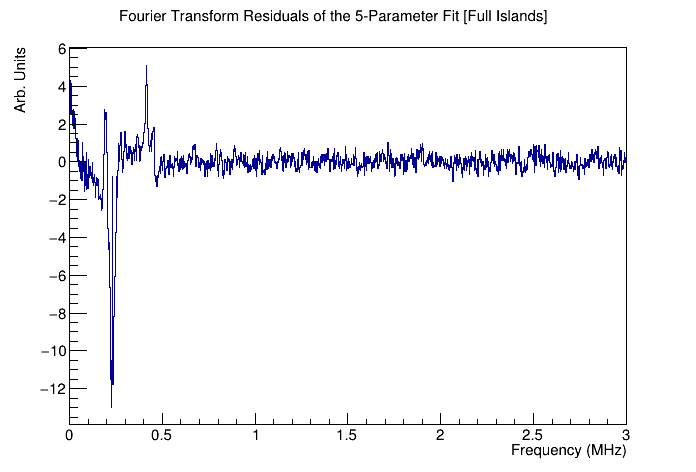

In [79]:
c = r.TCanvas()
residDiff_5param.GetXaxis().SetRangeUser(0,3)
residDiff_5param.Draw("hist")
c.Draw()

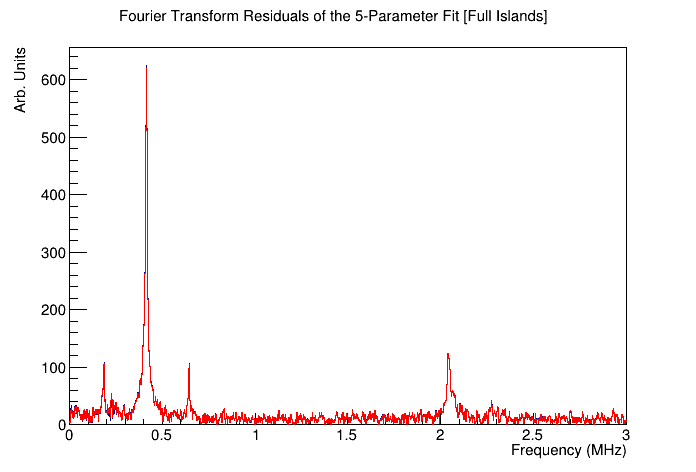

In [80]:
c = r.TCanvas()

residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals5paramXform_TruncIslands.SetLineColor(2)
residuals5paramXform_TruncIslands.Draw("hist SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


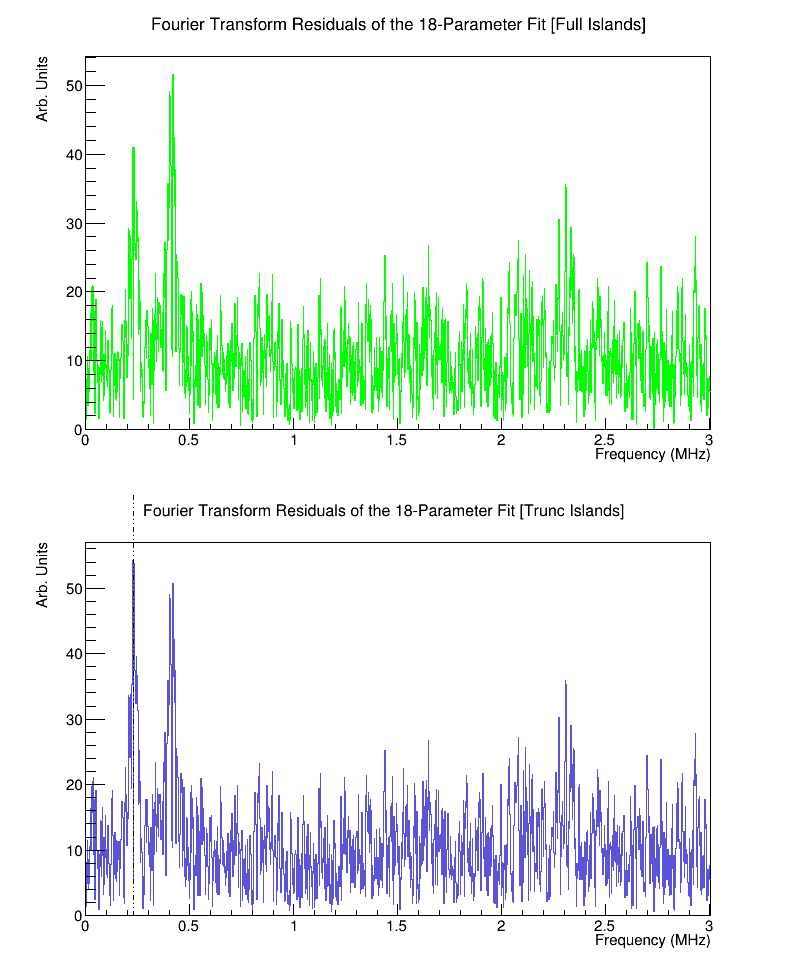

In [91]:
c = r.TCanvas("c","c",800,1000)
c.Divide(1,2)
c.cd(1)

residuals18paramXform_FullIslands.Draw("hist")
residuals18paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals18paramXform_FullIslands.SetLineColor(3)
residuals18paramXform_TruncIslands.SetLineColor(9)
c.cd(2)
residuals18paramXform_TruncIslands.GetXaxis().SetRangeUser(0,3)
residuals18paramXform_TruncIslands.Draw("hist")
#residuals5paramXform_TruncIslands.Draw("hist SAME")

f_omega_a.Draw("SAME")

c.Draw()

In [83]:
residDiff_18param = residuals18paramXform_FullIslands.Clone("residDiff_18param")
residDiff_18param.GetXaxis().SetRangeUser(0,3)
residDiff_18param.Add(residuals18paramXform_TruncIslands, -1)
residDiff_18param.SetTitle("18-Parameter Residuals: Full - Trunc")

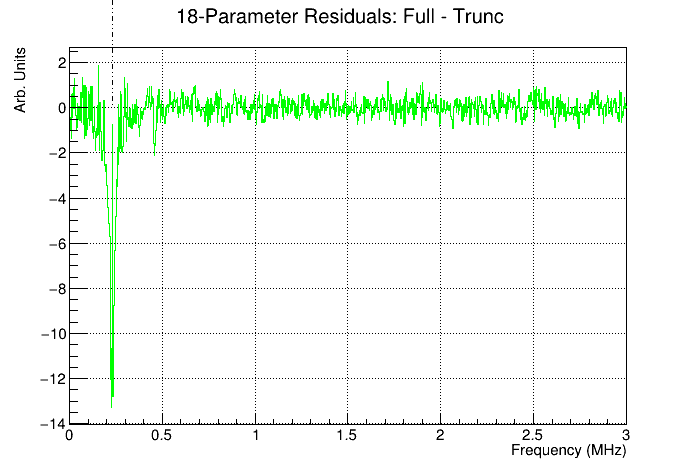

In [84]:
c = r.TCanvas()
residDiff_18param.Draw("hist")
residDiff_18param.GetXaxis().SetRangeUser(0,3)
f_omega_a.Draw("SAME")
c.SetGrid()
c.Draw()

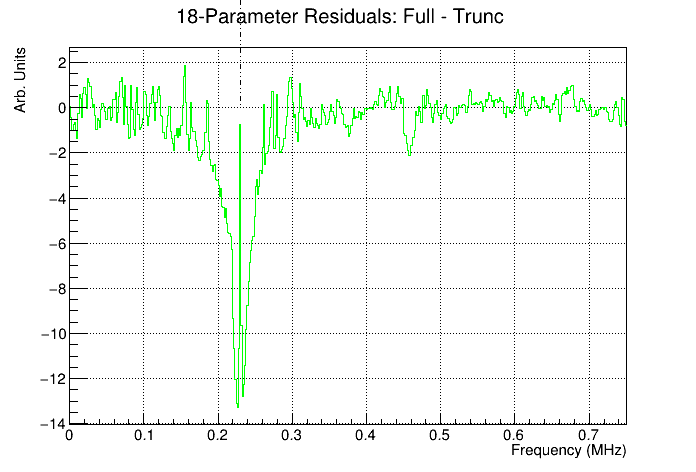

In [85]:
c = r.TCanvas()
residDiff_18param.Draw("hist")
residDiff_18param.GetXaxis().SetRangeUser(0,0.75)
f_omega_a.Draw("SAME")
c.SetGrid()
c.Draw()